## Projet Final : Vendée Globe

In [84]:
%matplotlib notebook
from bs4 import BeautifulSoup
import sys
import pandas as pd
import numpy as np
import requests
import re
import urllib
import os
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re
import datetime as dt
import seaborn as sns
import cartopy as ctp
from plotly.offline import init_notebook_mode, plot, iplot
import plotly as py
init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import warnings            
warnings.filterwarnings("ignore") 
import os
import cartopy.crs as ccrs
from plotly.offline import init_notebook_mode, plot, iplot
import plotly as py
init_notebook_mode(connected=True) 
import plotly.graph_objs
import plotly.express as px

# Récupération des fichiers Excel avec les classements

- Je récupère les fichiers de classement : 
 - par le parsing du fichier html 'https://www.vendeeglobe.org/fr/classement' avec le package beautifullsoup pour récupérer le nom des fichiers
 - je télecharge les fichiers dans l'url 'https://www.vendeeglobe.org/download-race-data/' avec le préfixe vendeeglobe_nom du fichier

- Les fichiers sont ensuite débarassés de leurs attributs xml = xxid qui les rend incompatibles avec pandas.read_excel

- Je nettoie les doublons

- Les fichiers sont stockés dans un répertoire local ce qui permet de ne recharger que les nouveaux fichiers en cas de nouveau lancement du script.

In [5]:
# Je crée le répertoire de destination des fichiers que je récupère
rep_data_course ='data_course'

# Je charge les fichiers de classement dans un répertoire 
url = 'https://www.vendeeglobe.org/fr/classement'
urld_root = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'


# Script pour enlever l'attribut xxid dans le titre des fichiers et les rendre utilisables par pandas.
def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)          
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


def get_soup_from_url(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    return soup


def valeurs_correctes(value):
    return value and re.compile("[0-9]{8}_[0-9]{6}").search(value)

soup= get_soup_from_url(url)
liste_classement = soup.find('select', {'class': "form__input m--select onsubmit-rank"})
liste_classement = liste_classement.find_all(value = valeurs_correctes)

# Je supprime les doublons
u= {v.attrs['value']:v for v in liste_classement}
url_to_download= [[urld_root + v.attrs['value']+'.xlsx',v.attrs['value']] for k,v in u.items()]
dirf='.'+ os.sep + rep_data_course
print(f'Nombre de fichiers à télécharger {len(url_to_download) - len(os.listdir(dirf))}')
print(f'Nombre de fichiers déjà présents {len(os.listdir(dirf))}')
pth=os.getcwdb().decode('utf-8')
if not os.path.exists(os.getcwdb().decode('utf-8')+str(os.sep)+ str(rep_data_course)):
    os.mkdir('./'+rep_data_course)

for j in range (1,len(url_to_download)):
    sys.stdout.write(f"Download progress: {round(100* j /len(url_to_download),0)}% \r")
    sys.stdout.flush()
    
    if not os.path.exists(pth + os.sep + rep_data_course + os.sep + url_to_download[j][1]+'.xlsx'):
        urllib.request.urlretrieve(url_to_download[j][0], rep_data_course+ '/' + url_to_download[j][1]+'.xlsx')

for j in range (1,len(url_to_download)):
    sys.stdout.write(f"Change xxid progress: {round(100* j /len(url_to_download),0)}% \r")
    sys.stdout.flush()
    change_in_zip(rep_data_course+ '/' + url_to_download[j][1]+'.xlsx', name_filter='xl/styles.xml', change=lambda d: re.sub(b'xxid="\d*"', b"", d))

Nombre de fichiers à télécharger 703
Nombre de fichiers déjà présents 0


## Création du dataset

Les fonctions ci-dessous permettent de générer le dataframe de classement à partir des fichiers télechargés. 

Chaque fichier est lu et l'ensemble des colonnes sont parsées en respectant les types de données (avec encore un nettoyage).

In [7]:
# Je charge les fichiers
fichiers = os.listdir(pth + os.sep + rep_data_course)
print( pth + os.sep + rep_data_course+ os.sep +fichiers[0] )

# Je crée le dataset
def dms2dec(deg, mn, sec):
    return deg + mn/60 + sec/3600

def classement_to_pandas(list_fichiers):
    j = 0
    accDF = pd.DataFrame()
    for i in list_fichiers:
        filename = pth + os.sep + rep_data_course+ os.sep +i
        
        df = pd.read_excel(filename, header = 4)
       
        
        df = df.drop(df.columns[[0]], axis='columns')
        
        df.columns = ['Rang', 'Nat. / Voile', 'Skipper', 'Heure FR',
              'Latitude', 'Longitude', 'Cap Depuis 30 minutes (deg)',
              'Vitesse Depuis 30 minutes (kts)', 'VMG Depuis 30 minutes (kts)',
              'Distance Depuis 30 minutes (nm)', 'Cap Depuis le dernier classement (deg)',
              'Vitesse Depuis le dernier classement (kts)', 'VMG Depuis le dernier classement (kts)',
              'Distance Depuis le dernier classement (nm)', 'Cap Depuis 24 heures (deg)',
              'Vitesse Depuis 24 heures (kts)', 'VMG Depuis 24 heures (kts)',
              'Distance Depuis 24 heures (nm)', 'DTF (nm)', 'DTL (nm)']
        
        df = df.dropna()
        df['Skipper'] = df['Skipper'].apply(lambda x : x.split('\n')[0].strip())
        df['Skipper'] = df['Skipper'].str.title()
        df['Rang'] = df['Rang'].apply(lambda x : int(x))
        df = df.replace({'\n': ' '}, regex=True)
        df.insert(0, 'Date', dt.datetime(int(i[0:4]),int(i[4:6]), int(i[6:8]), int(i[9:11]), int(i[11:13]), int(i[13:15])))
        
        sys.stdout.write(f"Chargement DF progress: {round(100* j /len(list_fichiers),0)}% \r")
        sys.stdout.flush()
        accDF = pd.concat([accDF, df])
        j+=1
            
    df = accDF 
    df['Cap Depuis 30 minutes (deg)'] = df['Cap Depuis 30 minutes (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Cap Depuis le dernier classement (deg)'] = df['Cap Depuis le dernier classement (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Cap Depuis 24 heures (deg)'] = df['Cap Depuis 24 heures (deg)'].apply(lambda x : float(str(x)[0:-1]))
    df['Vitesse Depuis 30 minutes (kts)'] = df['Vitesse Depuis 30 minutes (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis 30 minutes (kts)'] = df['VMG Depuis 30 minutes (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Vitesse Depuis le dernier classement (kts)'] = df['Vitesse Depuis le dernier classement (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis le dernier classement (kts)'] = df['VMG Depuis le dernier classement (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Vitesse Depuis 24 heures (kts)'] = df['Vitesse Depuis 24 heures (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['VMG Depuis 24 heures (kts)'] = df['VMG Depuis 24 heures (kts)'].apply(lambda x : float(str(x)[0:-4]))
    df['Distance Depuis 30 minutes (nm)'] = df['Distance Depuis 30 minutes (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Distance Depuis le dernier classement (nm)'] = df['Distance Depuis le dernier classement (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Distance Depuis 24 heures (nm)'] = df['Distance Depuis 24 heures (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['Latitude'] = df['Latitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'N' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['Longitude'] = df['Longitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'E' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['DTF (nm)'] = df['DTF (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df['DTL (nm)'] = df['DTL (nm)'].apply(lambda x : float(str(x)[0:-3]))
    df.reset_index(drop = True, inplace = True)
    return df



/Users/Marie/Python/Marie Campo - Tvx rendus/Projet/data_course/20201127_140000.xlsx


In [85]:
fichiers = os.listdir(pth + os.sep + rep_data_course)
df_classement = classement_to_pandas(fichiers)
df_classement.head()


Date Rang Nat. / Voile           Skipper   Heure FR  \
0 2020-11-27 14:00:00    1       FRA 79     Charlie Dalin  14:30 FR    
1 2020-11-27 14:00:00    2       FRA 59     Thomas Ruyant  14:30 FR    
2 2020-11-27 14:00:00    3       FRA 01       Jean Le Cam  14:30 FR    
3 2020-11-27 14:00:00    4       FRA 17  Yannick Bestaven  14:30 FR    
4 2020-11-27 14:00:00    5       FRA 85   Kevin Escoffier  14:30 FR    

    Latitude  Longitude  Cap Depuis 30 minutes (deg)  \
0 -40.471667  -8.812778                         68.0   
1 -37.021111 -13.075556                        181.0   
2 -35.703333 -13.177500                        110.0   
3 -37.966667 -17.610000                        105.0   
4 -36.062500 -17.351111                        107.0   

   Vitesse Depuis 30 minutes (kts)  VMG Depuis 30 minutes (kts)  ...  \
0                             19.5                         14.6  ...   
1                             13.5                          5.5  ...   
2                             17.1                         16.9  ...   
3                             16.1                         15.8  ...   
4                             17.1                         16.9  ...   

   Cap Depuis le dernier classement (deg)  \
0                                    76.0   
1                                   182.0   
2                                   119.0   
3                                   112.0   
4                                   114.0   

   Vitesse Depuis le dernier classement (kts)  \
0                                        21.3   
1                                        12.8   
2                                        16.5   
3                                        17.5   
4                                        17.2   

   VMG Depuis le dernier classement (kts)  \
0                                    17.9   
1                                     5.2   
2                                    16.5   
3                                    17.4   
4                                    17.2   

   Distance Depuis le dernier classement (nm)  Cap Depuis 24 heures (deg)  \
0                                        63.9                       131.0   
1                                        38.3                       176.0   
2                                        49.4                       150.0   
3                                        52.5                       131.0   
4                                        51.7                       127.0   

   Vitesse Depuis 24 heures (kts)  VMG Depuis 24 heures (kts)  \
0                            11.2                        10.9   
1                             5.9                         3.2   
2                            11.2                        10.1   
3                            13.5                        13.3   
4                            12.6                        12.6   

   Distance Depuis 24 heures (nm)  DTF (nm)  DTL (nm)  
0                           269.9   18580.0       0.0  
1                           142.6   18880.8     300.9  
2                           269.8   18950.1     370.2  
3                           323.0   19052.5     472.5  
4                           303.4   19065.9     486.0  

[5 rows x 21 columns]

Le dataframe est sauvegardé sous format Pickle pour en disposer sur le disque sans refaire toutes les opérations de nettoyage.

In [86]:
df_classement.to_pickle('./df_classement')


## Chargement du Dataframe à partir du fichier Pickle sur le répertoire local
<a id='cell_pickle'></a>

In [87]:
# Je charge le dataframe depuis le fichier pickle
df_classement=pd.read_pickle('./df_classement')
df_classement.head()

Date Rang Nat. / Voile           Skipper   Heure FR  \
0 2020-11-27 14:00:00    1       FRA 79     Charlie Dalin  14:30 FR    
1 2020-11-27 14:00:00    2       FRA 59     Thomas Ruyant  14:30 FR    
2 2020-11-27 14:00:00    3       FRA 01       Jean Le Cam  14:30 FR    
3 2020-11-27 14:00:00    4       FRA 17  Yannick Bestaven  14:30 FR    
4 2020-11-27 14:00:00    5       FRA 85   Kevin Escoffier  14:30 FR    

    Latitude  Longitude  Cap Depuis 30 minutes (deg)  \
0 -40.471667  -8.812778                         68.0   
1 -37.021111 -13.075556                        181.0   
2 -35.703333 -13.177500                        110.0   
3 -37.966667 -17.610000                        105.0   
4 -36.062500 -17.351111                        107.0   

   Vitesse Depuis 30 minutes (kts)  VMG Depuis 30 minutes (kts)  ...  \
0                             19.5                         14.6  ...   
1                             13.5                          5.5  ...   
2                             17.1                         16.9  ...   
3                             16.1                         15.8  ...   
4                             17.1                         16.9  ...   

   Cap Depuis le dernier classement (deg)  \
0                                    76.0   
1                                   182.0   
2                                   119.0   
3                                   112.0   
4                                   114.0   

   Vitesse Depuis le dernier classement (kts)  \
0                                        21.3   
1                                        12.8   
2                                        16.5   
3                                        17.5   
4                                        17.2   

   VMG Depuis le dernier classement (kts)  \
0                                    17.9   
1                                     5.2   
2                                    16.5   
3                                    17.4   
4                                    17.2   

   Distance Depuis le dernier classement (nm)  Cap Depuis 24 heures (deg)  \
0                                        63.9                       131.0   
1                                        38.3                       176.0   
2                                        49.4                       150.0   
3                                        52.5                       131.0   
4                                        51.7                       127.0   

   Vitesse Depuis 24 heures (kts)  VMG Depuis 24 heures (kts)  \
0                            11.2                        10.9   
1                             5.9                         3.2   
2                            11.2                        10.1   
3                            13.5                        13.3   
4                            12.6                        12.6   

   Distance Depuis 24 heures (nm)  DTF (nm)  DTL (nm)  
0                           269.9   18580.0       0.0  
1                           142.6   18880.8     300.9  
2                           269.8   18950.1     370.2  
3                           323.0   19052.5     472.5  
4                           303.4   19065.9     486.0  

[5 rows x 21 columns]

In [143]:
# Top 5 des Skipper avec les Plus grandes distances parcourrues en 24h 
def maxdist(df):
    return df.loc[df['Distance Depuis 24 heures (nm)'].idxmax(), ['Distance Depuis 24 heures (nm)','Date']]
df_classement.groupby(['Skipper']).apply(maxdist).sort_values(['Distance Depuis 24 heures (nm)'], ascending=False).iloc[0:5]

Distance Depuis 24 heures (nm)                Date
Skipper                                                            
Thomas Ruyant                             515.3 2020-11-21 11:00:00
Sébastien Simon                           508.8 2020-11-21 08:00:00
Charlie Dalin                             505.5 2020-11-20 04:00:00
Alex Thomson                              501.8 2020-11-21 08:00:00
Armel Tripon                              498.2 2020-12-02 21:00:00

In [144]:
#Meilleure Vitesse moyenne en 24 heures 
def maxspeed(df):
    return df.loc[df['Vitesse Depuis 24 heures (kts)'].idxmax(), ['Vitesse Depuis 24 heures (kts)','Date']]
df_classement.groupby(['Skipper']).apply(maxspeed).sort_values(['Vitesse Depuis 24 heures (kts)'], ascending=False).iloc[0:5]

Vitesse Depuis 24 heures (kts)                Date
Skipper                                                            
Thomas Ruyant                              21.5 2020-11-21 11:00:00
Sébastien Simon                            21.2 2020-11-21 08:00:00
Charlie Dalin                              21.1 2020-11-20 04:00:00
Alex Thomson                               20.9 2020-11-21 04:00:00
Armel Tripon                               20.8 2020-12-02 21:00:00

In [145]:
#5 Meilleures Vitesses entre classement 
def maxspeed_clst(df):
    return df.loc[df['Vitesse Depuis le dernier classement (kts)'].idxmax(), ['Vitesse Depuis le dernier classement (kts)','Date']]
df_classement.groupby(['Skipper']).apply(maxspeed_clst).sort_values(['Vitesse Depuis le dernier classement (kts)'], ascending=False).iloc[0:5]

Vitesse Depuis le dernier classement (kts)  \
Skipper                                                        
Thomas Ruyant                                           23.9   
Jérémie Beyou                                           23.7   
Armel Tripon                                            23.6   
Charlie Dalin                                           23.4   
Nicolas Troussel                                        22.9   

                                Date  
Skipper                               
Thomas Ruyant    2020-11-08 17:00:00  
Jérémie Beyou    2020-11-08 17:00:00  
Armel Tripon     2020-11-08 17:00:00  
Charlie Dalin    2020-11-21 11:00:00  
Nicolas Troussel 2020-11-08 17:00:00

In [146]:
#Meilleures des 5 Vitesses sur 30 minutes avant classement 
def maxspeed_clst_30(df):
    return df.loc[df['Vitesse Depuis 30 minutes (kts)'].idxmax(), ['Vitesse Depuis 30 minutes (kts)','Date']]
df_classement.groupby(['Skipper']).apply(maxspeed_clst_30).sort_values(['Vitesse Depuis 30 minutes (kts)'], ascending=False).iloc[0:5]

Vitesse Depuis 30 minutes (kts)                Date
Skipper                                                              
Jérémie Beyou                                26.0 2020-11-08 15:00:00
Charlie Dalin                                24.8 2020-11-08 15:00:00
Nicolas Troussel                             24.4 2020-11-08 15:00:00
Thomas Ruyant                                24.3 2020-11-08 15:00:00
Armel Tripon                                 24.1 2020-12-07 17:00:00

In [147]:
#Nombre de fois premier au classement / Skipper
def nb_rang1(df):
    return df.loc[(df['Rang']==1),['Rang']].count()
df_classement.groupby(['Skipper']).apply(nb_rang1).sort_values(['Rang'], ascending=False)[0:5]

Rang
Skipper               
Charlie Dalin      224
Yannick Bestaven   157
Alex Thomson        46
Thomas Ruyant       20
Jean Le Cam          9

In [148]:
#Nombre de classement dans le rang x pour chaque conccurent
df_cross=pd.crosstab(df_classement.Skipper, df_classement.Rang)
df_cross

Rang                   1    2    3    4   5    6   7   8   9    10  ...   24  \
Skipper                                                             ...        
Alan Roura              0    0    0    0   0    0   0   0   0    0  ...    5   
Alex Thomson           46   13    7    3   5    2   2  17   1    4  ...    0   
Alexia Barrier          0    0    0    0   0    0   0   0   0    0  ...  313   
Ari Huusela             0    0    0    0   0    0   0   0   0    0  ...    0   
Armel Tripon            0    0    1    0   0    1   1   0   0    1  ...   51   
Arnaud Boissieres       0    0    0    0   0    0   0   0   0    0  ...   10   
Benjamin Dutreux        1    8   14   10  60  104  77  49  70   24  ...    1   
Boris Herrmann          0   14   53   44  50   76  71  97  25    7  ...    0   
Charlie Dalin         224  159   44   17   4    7   4   4   3    1  ...    0   
Clarisse Cremer         0    0    0    0   0    0   0   1   0    0  ...    0   
Clément Giraud          0    0    0    0   0    0   0   0   0    0  ...  185   
Damien Seguin           5    6   36  116  81   66  54  13  21    8  ...    0   
Didac Costa             0    0    0    0   0    0   0   0   0    0  ...    9   
Fabrice Amedeo          0    0    0    0   0    1   0   0   0    0  ...   20   
Giancarlo Pedote        0    0    0    0   0    8  69  54  80  135  ...    2   
Isabelle Joschke        0    0    0    0   6   13  11  59  94   17  ...    0   
Jean Le Cam             9   24   63   83  57   68  67  65  50    0  ...    0   
Jérémie Beyou           5    0    1    2   0    1   2   1   2    0  ...    1   
Kevin Escoffier         0    0    9   35  57    8   7   2   3    4  ...    0   
Kojiro Shiraishi        0    0    0    0   0    0   0   0   0    1  ...   15   
Louis Burton            7   77   47   22  52   63  40  40  16   26  ...    1   
Manuel Cousin           0    0    0    0   0    0   0   0   1    2  ...    7   
Maxime Sorel            8    5    0    0   6    1   6  20  40  182  ...    0   
Miranda Merron          0    0    0    0   0    0   0   0   0    0  ...   19   
Nicolas Troussel        0    4    2   10   5    7   4   2   2    2  ...    0   
Pip Hare                0    0    0    0   0    0   0   0   0    1  ...   31   
Romain Attanasio        0    0    0    1   3    6   2   0   5    5  ...    0   
Samantha Davies         0    0    0    1   0    0   4  19  44   39  ...    0   
Stéphane Le Diraison    0    0    0    1   0    0   3   4   1    0  ...    0   
Sébastien Destremau     0    0    0    0   0    0   0   0   1    0  ...    0   
Sébastien Simon         0    0    1    8   3    3  37   7  17   12  ...    0   
Thomas Ruyant          20  152  168  104   5    5   8   2   3    4  ...    0   
Yannick Bestaven      157   21   37   27  91   46  17  32  12   21  ...    0   

Rang                   25   26   27  28  29  30  31  32  33  
Skipper                                                      
Alan Roura              2    1    4   1   0   0   0   0   0  
Alex Thomson            0    0    0   0   0   0   0   0   0  
Alexia Barrier        160   40   26  25  24   3   7   7   0  
Ari Huusela           347  183   77  23  58   5   1   2   0  
Armel Tripon           11    7    1  10   9   6   3   2   0  
Arnaud Boissieres       3    1    2   2   4   5   0   0   0  
Benjamin Dutreux        1    0    0   0   0   0   0   0   0  
Boris Herrmann          0    0    0   0   1   0   0   0   0  
Charlie Dalin           1    0    0   0   0   0   0   0   0  
Clarisse Cremer         0    0    0   0   0   0   0   0   0  
Clément Giraud         50   28   17  33   9  43   2   0   0  
Damien Seguin           0    0    0   0   0   0   0   0   0  
Didac Costa             3    1    1   0   0   0   0   0   0  
Fabrice Amedeo         38    2    9   3   2  12  24  23  24  
Giancarlo Pedote        0    0    1   4   0   0   0   0   0  
Isabelle Joschke        0    0    0   1   0   0   0   0   0  
Jean Le Cam             0    0    0   0   0   0   0   0   0  
Jérémie Beyou        

# Extraction des caractéristiques techniques de chacun des voiliers

Les caractéristiques des bateaux sont concentrées dans le glossaire 3D du site du vendée globe, à l'url suivante : https://www.vendeeglobe.org/fr/glossaire

Je réalise un parsing via le package beautifullsoup : 
- Je décide d'utiliser le nom des skippers comme clé entre les datasets
- J'ai noté trois divergences entre les datasets sur ces noms qui m'empêchent de joindre le dataset des caractéristiques des bateaux avec celui du classement : je les ai donc corrigées.
 - Samantha Davies a le diminutif 'Sam'
 - Il manque un accent grave sur le nom de famille de Arnaud Boissières
 - Il y a un espace en trop pour Alan Roura
- De plus, je rajoute la caractéristique foil à mon dataset pour analyse ultérieure


In [88]:
def extraction_specification(url):
    req = requests.get(url)
    soup = BeautifulSoup( req.content, 'html.parser')
    
    tag = soup.findAll("ul", {"class": "boats-list__popup-specs-list"})
    data=[{re.match( r"([^:]*):",li.string).group(1).strip() : re.match( r".*:(.*)",li.string).group(1).strip() for li in t.find_all('li')} for t in tag]
    
    df= pd.DataFrame(data)
    
    tag = soup.findAll("h3", {"class": "boats-list__popup-title"})
    bnames = [i.string for i in tag] 
    
    tag = soup.findAll("span", {"class": "boats-list__skipper-name"})
    snames = [i.string for i in tag]
    
    df.insert(0, 'Bateau', bnames)
    df.insert(0, 'Skipper', snames)
    
    # Je corrige les écarts sur les noms des skippers entre les datasets 
    
    df.loc[df['Skipper'].str.contains('Sam'),'Skipper']='Samantha Davies'
    df.loc[df['Skipper'].str.contains('Alan'),'Skipper']='Alan Roura'
    df.loc[df['Skipper'].str.contains('Arnaud'),'Skipper']='Arnaud Boissieres'    
    df['Skipper'] = df['Skipper'].str.title()
       
    # Extraction des valeurs numériques et suppression des unités
    
    df['Longueur'] = df['Longueur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    df['Largeur'] = df['Largeur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    df["Tirant d'eau"] = df["Tirant d'eau"].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    df["Déplacement (poids)"] = df["Déplacement (poids)"].apply(lambda x : ((str(x).replace(',', '.')).replace('tonne', ''))[0:-1])
    df["Hauteur mât"] = df["Hauteur mât"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-1])
    df["Surface de voiles au près"] = df["Surface de voiles au près"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-2])
    df["Surface de voiles au portant"] = df["Surface de voiles au portant"].apply(lambda x : (str(x).replace(',', '.'))[0:-2])
    
    pd.to_numeric(df["Surface de voiles au portant"], errors='raise')
    pd.to_numeric(df['Longueur'], errors='raise')
    pd.to_numeric(df["Tirant d'eau"], errors='raise')
    pd.to_numeric(df["Déplacement (poids)"], errors='coerce')
    pd.to_numeric(df["Hauteur mât"], errors='raise')
    pd.to_numeric(df["Surface de voiles au près"], errors='raise')
    pd.to_numeric(df["Surface de voiles au près"], errors='raise')
    
    # Ajout du paramètres à des Foils dans la colonne Foils
    df["Foils"]= df['Nombre de dérives'].apply(lambda x: 'oui' if 'foils' in x else 'non')
    
    return df

In [89]:
df_bateau = extraction_specification("https://www.vendeeglobe.org/fr/glossaire")
df_bateau.head()

df_bateau


Skipper                              Bateau Numéro de voile  \
0         Fabrice Amedeo            NEWREST - ART & FENÊTRES          FRA 56   
1       Romain Attanasio                PURE - Best Western®          FRA 49   
2         Alexia Barrier                    TSE -  4MYPLANET           FRA72   
3       Yannick Bestaven                       Maître CoQ IV              17   
4          Jérémie Beyou                              CHARAL              08   
5      Arnaud Boissieres   LA MIE CÂLINE - ARTISANS ARTIPÔLE          FRA 14   
6           Louis Burton                     BUREAU VALLEE 2              18   
7            Didac Costa                ONE PLANET ONE OCEAN          ESP 33   
8          Manuel Cousin                        GROUPE SÉTIN          FRA 71   
9        Clarisse Cremer                  BANQUE POPULAIRE X           FRA30   
10         Charlie Dalin                              APIVIA          FRA 79   
11       Samantha Davies                   INITIATIVES-COEUR          FRA109   
12   Sébastien Destremau                               MERCI              69   
13      Benjamin Dutreux                OMIA - WATER FAMILY            FRA09   
14       Kevin Escoffier                                 PRB          FRA 85   
15        Clément Giraud           Compagnie du Lit / Jiliti           FRA83   
16              Pip Hare                            MEDALLIA           GBR77   
17        Boris Herrmann  SEAEXPLORER - YACHT CLUB DE MONACO              16   
18           Ari Huusela                               STARK          FIN222   
19      Isabelle Joschke                               MACSF          FRA 27   
20           Jean Le Cam                         Yes We Cam!             001   
21  Stéphane Le Diraison                     TIME FOR OCEANS          FRA 92   
22        Miranda Merron                  CAMPAGNE DE FRANCE           FRA50   
23      Giancarlo Pedote                      PRYSMIAN GROUP          ITA 34   
24            Alan Roura                         LA FABRIQUE           SUI07   
25         Thomas Ruyant                           LinkedOut             NaN   
26         Damien Seguin                       GROUPE APICIL         FRA1000   
27      Kojiro Shiraishi                 DMG MORI Global One          JPN 11   
28       Sébastien Simon                        ARKEA PAPREC               4   
29          Maxime Sorel                     V and B-MAYENNE           FRA53   
30          Alex Thomson                           HUGO BOSS          GBR 99   
31          Armel Tripon              L'OCCITANE EN PROVENCE               2   
32      Nicolas Troussel                     CORUM L'EPARGNE           FRA 6   

                               Anciens noms du bateau  \
0                      No Way Back, Vento di Sardegna   
1            Gitana Eighty, Synerciel, Newrest-Matmut   
2   Famille Mary-Etamine du Lys, Initiatives Coeur...   
3                       Safran 2 - Des Voiles et Vous   
4                                                 NaN   
5   Ecover3, Président, Gamesa, Kilcullen Voyager-...   
6                               Banque Populaire VIII   
7   Kingfisher - Educacion sin Fronteras - Forum M...   
8   Paprec-Virbac2, Estrella Damm, We are Water, L...   
9                                         Macif - SMA   
10                                                NaN   
11       Maître CoQ - Banque Populaire VII- Foncia II   
12              Foresight Natural Energy, Maisonneuve   
13  Spirit of Yukoh, Neutrogena, Hugo Boss, Estrel...   
14                                                NaN   
15  Delta Dore, Bureau Vallée, Vers un Monde sans ...   
16               Armor Lux, We Are Water, La Fabrique   
17  Edmond de Rothschild, Malizia - Yacht Club de ...   
18                      Aviva, GAES Centros Auditivos   
19                                  Quéguiner, Safran   
20  Cheminées Poujoulat, Mare, Maître CoQ, Mapfre,...   
21  Hugo Boss, Energa, Compagnie du Lit-Bo

# Rapprochement des données des voiliers avec celle des classements

In [110]:
def rapprochement_df(df_classement, df_bateau):
    df = pd.merge(df_classement, df_bateau, how='outer', on='Skipper', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    
    df = df.sort_values(by = ['Date', 'Rang'], ascending = [False, True])
    df.reset_index(drop = True, inplace = True)
    return df

In [124]:
df_RVMG = rapprochement_df(df_classement, df_bateau)

#Je remets à zéro les Distance Depuis le dernier classement pour la date min du dataset.
index_debut = df_RVMG.loc[df_RVMG['Date']==df_RVMG['Date'].min()].index
df_RVMG.loc[index_debut,'Distance Depuis le dernier classement (nm)']=0

#df_RVMG.loc[index_debut,'Distance Depuis le dernier classement (nm)']

#On fait la même chose pour ceux qui sont partis 1h après les 31 premiers (15h00 au lieu de 14h00)

index_debut = df_RVMG.loc[(df_RVMG['Distance Depuis le dernier classement (nm)']>2500)].index
df_RVMG.loc[index_debut,'Distance Depuis le dernier classement (nm)']=0
df_RVMG

            


Date Rang Nat. / Voile           Skipper        Heure FR  \
0     2021-03-05 04:00:00   25      FIN 222       Ari Huusela       04:30 FR    
1     2021-03-04 21:00:00   25      FIN 222       Ari Huusela       21:30 FR    
2     2021-03-04 17:00:00   25      FIN 222       Ari Huusela       17:30 FR    
3     2021-03-04 14:00:00   25      FIN 222       Ari Huusela       14:30 FR    
4     2021-03-04 11:00:00   25      FIN 222       Ari Huusela       11:30 FR    
...                   ...  ...          ...               ...             ...   
15267 2020-11-08 14:00:00   27       FRA 72    Alexia Barrier       15:30 FR    
15268 2020-11-08 14:00:00   28       FRA 27  Isabelle Joschke  15:26 FR -4min   
15269 2020-11-08 14:00:00   29        FRA 4   Sébastien Simon  15:29 FR -1min   
15270 2020-11-08 14:00:00   30       FRA 50    Miranda Merron  15:28 FR -2min   
15271 2020-11-08 14:00:00   31      FIN 222       Ari Huusela       15:30 FR    

        Latitude  Longitude  Cap Depuis 30 minutes (deg)  \
0      46.722500  -1.557778                        128.0   
1      47.145556  -2.175000                        107.0   
2      47.192500  -3.290000                         94.0   
3      47.222778  -4.647500                        106.0   
4      47.153056  -4.413611                         19.0   
...          ...        ...                          ...   
15267  46.439722  -0.174444                        236.0   
15268  46.427222  -0.193889                        238.0   
15269  46.437500  -0.179722                        235.0   
15270  46.427500  -0.190556                        237.0   
15271  46.434722  -0.194167                        234.0   

       Vitesse Depuis 30 minutes (kts)  VMG Depuis 30 minutes (kts)  ...  \
0                                 11.4                         11.3  ...   
1                                  8.7                          8.6  ...   
2                                 10.0                          9.7  ...   
3                                  6.7                          6.7  ...   
4                                  5.7                          0.5  ...   
...                                ...                          ...  ...   
15267                             10.9                         10.8  ...   
15268                             13.8                         13.5  ...   
15269                             13.4                         13.4  ...   
15270                             11.4                         11.3  ...   
15271                             12.1                         12.0  ...   

       Longueur  Largeur  Tirant d'eau  Déplacement (poids)  \
0        18.28     5.80          4.50                  8.5    
1        18.28     5.80          4.50                  8.5    
2        18.28     5.80          4.50                  8.5    
3        18.28     5.80          4.50                  8.5    
4        18.28     5.80          4.50                  8.5    
...         ...      ...           ...                  ...   
15267     18.28     5.54          4.50                    9   
15268    18.28     5.60          4.50                  7.7    
15269    18.28     5.70          4.50                    8    
15270    18.28     5.50          4.50                  8.5    
15271    18.28     5.80          4.50                  8.5    

       Nombre de dérives  Hauteur mât  Voile quille  \
0                      2           28         acier   
1                      2           28         acier   
2                      2           28         acier   
3                      2           28         acier   
4                      2           28         acier   
...                  ...          ...           ...   
15267                  2           29         acier   
15268              foils           27         acier   
15269             foiler           29    Inox usiné   
15270                  2           28       carbone   
15271                  2           28         acier 

In [134]:
#Je remets à zéro les Distance Depuis le dernier classement pour la date min du dataset.
index_debut = df_RVMG.loc[df_RVMG['Date']==df_RVMG['Date'].min()].index
#df_RVMG.loc[index_debut,'Distance Depuis le dernier classement (nm)']=0
#df_RVMG.loc[index_debut,'Distance Depuis le dernier classement (nm)']
index_debut = df_RVMG.loc[df_RVMG['Date']==df_RVMG['Date'].min()].index

df_etude_dist=df_RVMG.loc[:,['Date','Bateau','Skipper','Distance Depuis le dernier classement (nm)']]
df_etude_dist.sort_values(['Date'])
df_etude_dist['jour']= df_etude_dist['Date'].apply(lambda x: pd.Timestamp.date(x))
df_etude_dist.drop(index_debut,axis=0)

Date                     Bateau              Skipper  \
0     2021-03-05 04:00:00                      STARK          Ari Huusela   
1     2021-03-04 21:00:00                      STARK          Ari Huusela   
2     2021-03-04 17:00:00                      STARK          Ari Huusela   
3     2021-03-04 14:00:00                      STARK          Ari Huusela   
4     2021-03-04 11:00:00                      STARK          Ari Huusela   
...                   ...                        ...                  ...   
15236 2020-11-08 15:00:00           TSE -  4MYPLANET       Alexia Barrier   
15237 2020-11-08 15:00:00  Compagnie du Lit / Jiliti       Clément Giraud   
15238 2020-11-08 15:00:00                      MERCI  Sébastien Destremau   
15239 2020-11-08 15:00:00         CAMPAGNE DE FRANCE       Miranda Merron   
15240 2020-11-08 15:00:00                      STARK          Ari Huusela   

       Distance Depuis le dernier classement (nm)        jour  
0                                            62.2  2021-03-05  
1                                            36.5  2021-03-04  
2                                            26.1  2021-03-04  
3                                            10.5  2021-03-04  
4                                            22.7  2021-03-04  
...                                           ...         ...  
15236                                        20.1  2020-11-08  
15237                                        18.6  2020-11-08  
15238                                        18.8  2020-11-08  
15239                                        19.1  2020-11-08  
15240                                        19.1  2020-11-08  

[15241 rows x 5 columns]

# Corrélation et régression linéaire entre le classement et la vitesse utile  des voiliers

J'appelle le classement 'Rang' et la vitesse utile des voiliers 'VMG'

- Je commence par observer 3 bateaux pris au hasard pour discerner si une corrélation se dessine
- Je prépare le dataset pour effectuer les régressions sur les vitesses des voiliers.
- Je transforme le dataframe en numpy array pour utiliser sklearn


In [135]:
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import random

['MEDALLIA', 'Yes We Cam!', 'SEAEXPLORER - YACHT CLUB DE MONACO']


<IPython.core.display.Javascript object>


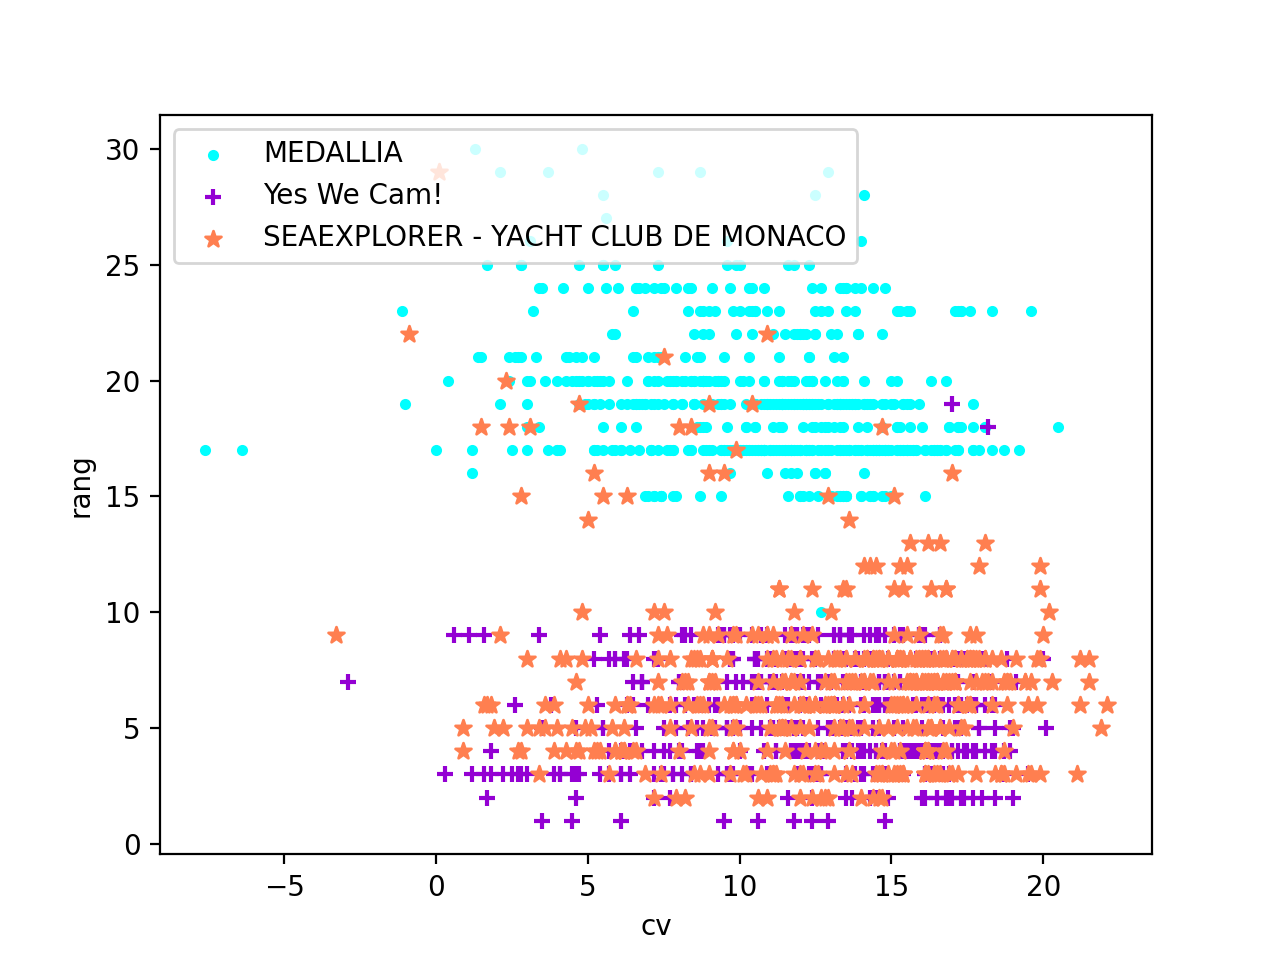

In [136]:
# observations dataset pour 3 bateaux pris au hasard (rang en fonction de la vitesse VMG )
n= 3
#Choix VMG 1 VMG/30 2
choix_vmg = 3
cv=['VMG Depuis 30 minutes (kts)', 'VMG Depuis le dernier classement (kts)',
                                   'VMG Depuis 24 heures (kts)'][choix_vmg-3]
# affiche la liste des bateaux 
lb = df_bateau['Bateau'].to_list()
lb = random.sample(lb,min(n,5))
colors=['aqua','darkviolet','coral']
tags = ['.','+','*']
print(lb)
def prep_df_plot(df,lb):
    df_b = df[['VMG Depuis 30 minutes (kts)', 'VMG Depuis le dernier classement (kts)',
                                   'VMG Depuis 24 heures (kts)', 'Rang', 'Bateau']]
    dfs={}
    for b in lb:
        dfs[b]=df_b.loc[df_b['Bateau'].apply(lambda x: x in b)].drop('Bateau',axis=1)
    return dfs
dfs= prep_df_plot(df_RVMG,lb)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('cv')
ax.set_ylabel('rang')


for i,b in enumerate(lb) :
    ax.scatter(np.array(dfs[b][[cv]]),np.array(dfs[b][['Rang']]),color=colors[i], marker =tags[i], label=b)
    ax.legend()#ax[i].plot(np.array(dfs[b]), RNG, "b.")
    

La corrélation sur des bateaux observés au hasard n'est pas flagrante...

<IPython.core.display.Javascript object>


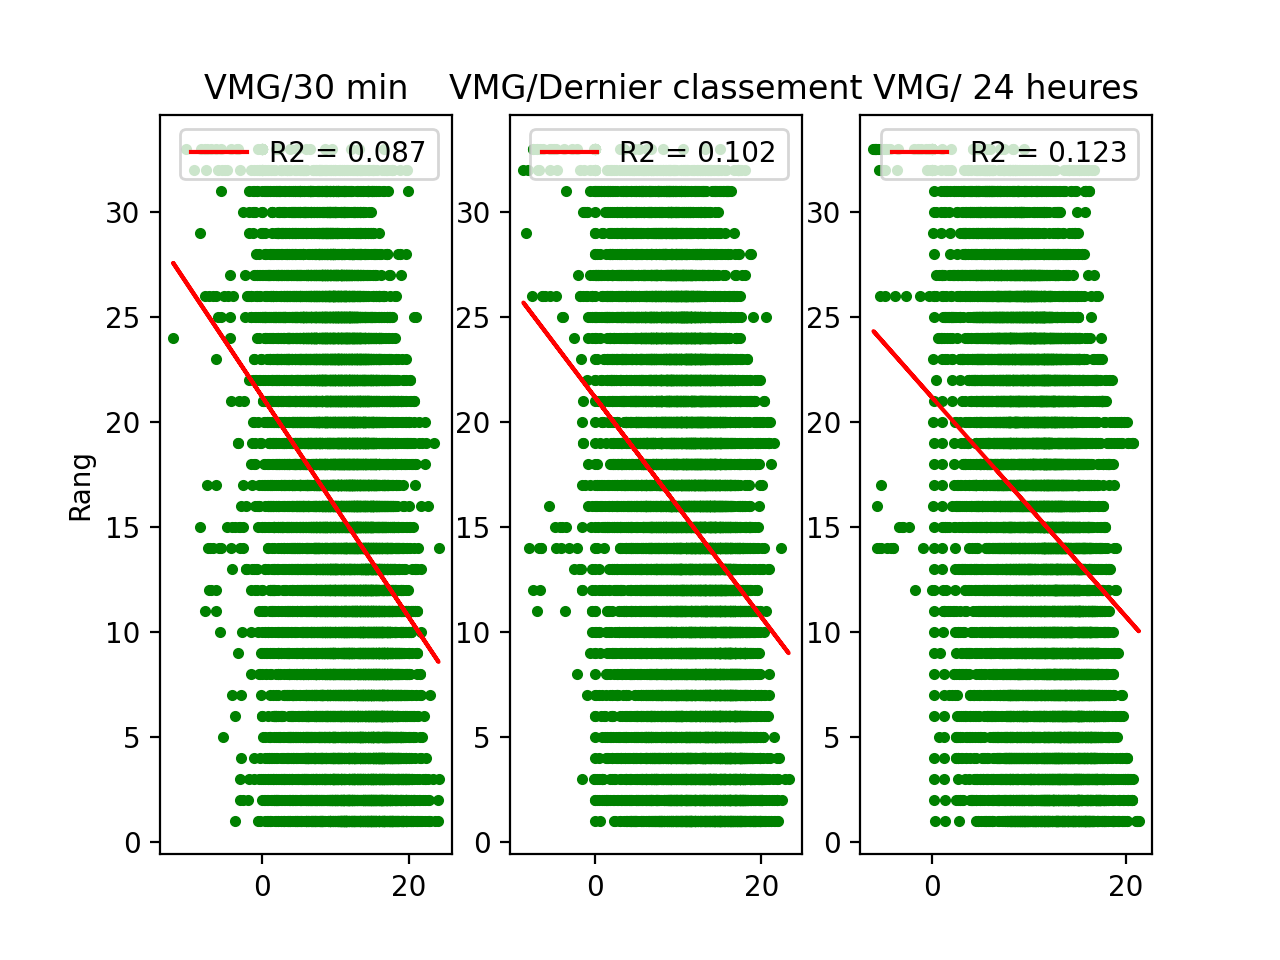

In [137]:
# Préparation du dataset pour la régression
def prep_df(df):
    return  np.array(pd.DataFrame(df[['VMG Depuis 30 minutes (kts)', 'VMG Depuis le dernier classement (kts)',
                                    'VMG Depuis 24 heures (kts)', 'Rang']]))
titres= ['VMG/30 min', 'VMG/Dernier classement','VMG/ 24 heures']
fig,ax = plt.subplots(1,3)
(plt.figure(fig)).figsize=(10,1)
RVMG = prep_df(df_RVMG)
RNG = RVMG[:,-1].reshape(-1, 1)
OLS= [LinearRegression(fit_intercept=True),LinearRegression(fit_intercept=True),LinearRegression(fit_intercept=True)]
VMG = [ RVMG[:,0].reshape(-1, 1),  RVMG[:,1].reshape(-1, 1),  RVMG[:,2].reshape(-1, 1)]
RNG = RVMG[:,-1].reshape(-1, 1)
OLSfit = [OLS[0].fit(VMG[0], RNG),OLS[1].fit(VMG[0], RNG),OLS[2].fit(VMG[0], RNG)]
y = [OLSfit[0].intercept_ + VMG[0]*OLSfit[0].coef_, OLSfit[1].intercept_ + VMG[1]*OLSfit[1].coef_ , OLSfit[2].intercept_ + VMG[2]*OLSfit[2].coef_]
    
for i in range(len(titres)):
    ax[i].set_title(titres[i])
    ax[i].plot(VMG[i], RNG, "g.")
    ax[i].plot(VMG[i], y[i], "r-", label =  'R2 = ' + str(OLSfit[i].score(VMG[i], RNG).round(3)))
    ax[i].legend()
ax[0].set_ylabel("Rang");
   

### Conclusion 
La pente de la droite de régression du rang en fonction des trois types de vitesses (VMGx) est négative, ce qui est attendu : plus la vitesse est grande, plus le classement est petit.
On constate que le R2 est faible, ce qui signifie que le modèle explique peu les données. On confirme la première impression sur la faible corrélation entre la vitesse et le rang. 
C'est tout à fait normal car la vitesse présente une variance très importante.  

## Impact de la présence d'un foil sur le classement et la vitesse des voiliers

- Pour cette analyse, j'attribue le rang nul aux voiliers ayant abandonné
- J'utilise la vitesse moyenne sur 24h

In [138]:
import datetime
df_stats_foils=df_RVMG[['Bateau','Foils','VMG Depuis 24 heures (kts)','Rang']].groupby(['Foils','Bateau']).agg(['mean','std'])
df_rang_course = df_RVMG[['Bateau','Date']].groupby('Bateau').max()
df_stats_foils= df_stats_foils.reset_index()
df_rang_course = df_rang_course.reset_index()
df_rang_course['LRang'] = df_rang_course[['Bateau','Date']].apply(lambda x: df_RVMG.iloc[df_RVMG.loc[(df_RVMG['Bateau']==x[0]) & (df_RVMG['Date']== datetime.datetime(2021,1,27,14,0,0))].index]['Rang'].values.squeeze(),axis=1 ) 
df_rang_course['LRang'] = df_rang_course['LRang'].apply (lambda x: int(x) if x.size>0 else 'abandon' )
df_stats_foils['LRang']=df_stats_foils['Bateau'].apply(lambda x: df_rang_course.loc[(df_rang_course['Bateau']==x)]['LRang'].values)
df_stats_foils['LRang']= df_stats_foils['LRang'].apply(lambda x: float(x) if x!='abandon' else 0)
df_stats_foils=df_stats_foils.set_index(['Foils','Bateau'])
df_stats_foils

VMG Depuis 24 heures (kts)            \
                                                               mean       std   
Foils Bateau                                                                    
non   ARKEA PAPREC                                        11.296835  5.730591   
      BANQUE POPULAIRE X                                  11.652199  2.879996   
      CAMPAGNE DE FRANCE                                   9.932512  2.807062   
      Compagnie du Lit / Jiliti                           10.073957  2.961993   
      GROUPE APICIL                                       12.493827  3.205601   
      GROUPE SÉTIN                                         9.707395  3.265061   
      MEDALLIA                                            10.537805  3.269028   
      MERCI                                                7.811031  3.602900   
      OMIA - WATER FAMILY                                 12.376986  3.151705   
      ONE PLANET ONE OCEAN                                10.358904  2.934766   
      PURE - Best Western®                                11.196673  2.853527   
      STARK                                                8.673752  2.655274   
      TSE -  4MYPLANET                                     9.077015  2.336122   
      V and B-MAYENNE                                     12.246371  2.823471   
      Yes We Cam!                                         12.408402  3.277500   
oui   APIVIA                                              12.604990  3.607991   
      BUREAU VALLEE 2                                     12.580952  3.959721   
      CHARAL                                              11.228015  4.950901   
      CORUM L'EPARGNE                                      9.376000  3.410522   
      DMG MORI Global One                                 10.595972  3.557601   
      HUGO BOSS                                           10.966667  5.362875   
      INITIATIVES-COEUR                                   10.688344  5.721493   
      L'OCCITANE EN PROVENCE                              11.930118  3.990627   
      LA FABRIQUE                                         10.641608  3.217397   
      LA MIE CÂLINE - ARTISANS ARTIPÔLE                   10.724558  3.643996   
      LinkedOut                                           12.539256  3.862018   
      MACSF                                               12.247340  3.306687   
      Maître CoQ IV                                       12.527329  3.850941   
      NEWREST - ART & FENÊTRES                             8.594000  4.099769   
      PRB                                                 12.180292  4.901093   
      PRYSMIAN GROUP                                      12.516461  3.407611   
      SEAEXPLORER - YACHT CLUB DE MONACO                  12.542268  3.404726   
      TIME FOR OCEANS                                     10.596684  2.943662   

                                               Rang           LRang  
                                               mean       std        
Foils Bateau                                                         
non   ARKEA PAPREC                        10.398734  4.103657   0.0  
      BANQUE POPULAIRE X                  13.508604  2.288030  12.0  
      CAMPAGNE DE FRANCE                  23.522167  1.987606  22.0  
      Compagnie du Lit / Jiliti           24.295492  2.500401  23.0  
      GROUPE APICIL                        6.382716  3.019802   6.0  
      GROUPE SÉTIN                        21.302251  1.848173  21.0  
      MEDALLIA                            19.221254  2.901796  19.0  
      MERCI                               27.872902  1.997753   0.0  
      OMIA - WATER FAMILY                  7.572301  2.769433   9.0  
      ONE PLANET ONE OCEAN                19.964041  1.527476  20.0  
      PURE - Best Western®                13.415896  1.900011  13.0  
      STARK                               25.955777  1.352051  25.0  
      TSE -  4MYPLANET                    24.819403  1.821294  24.0  
    

<IPython.core.display.Javascript object>


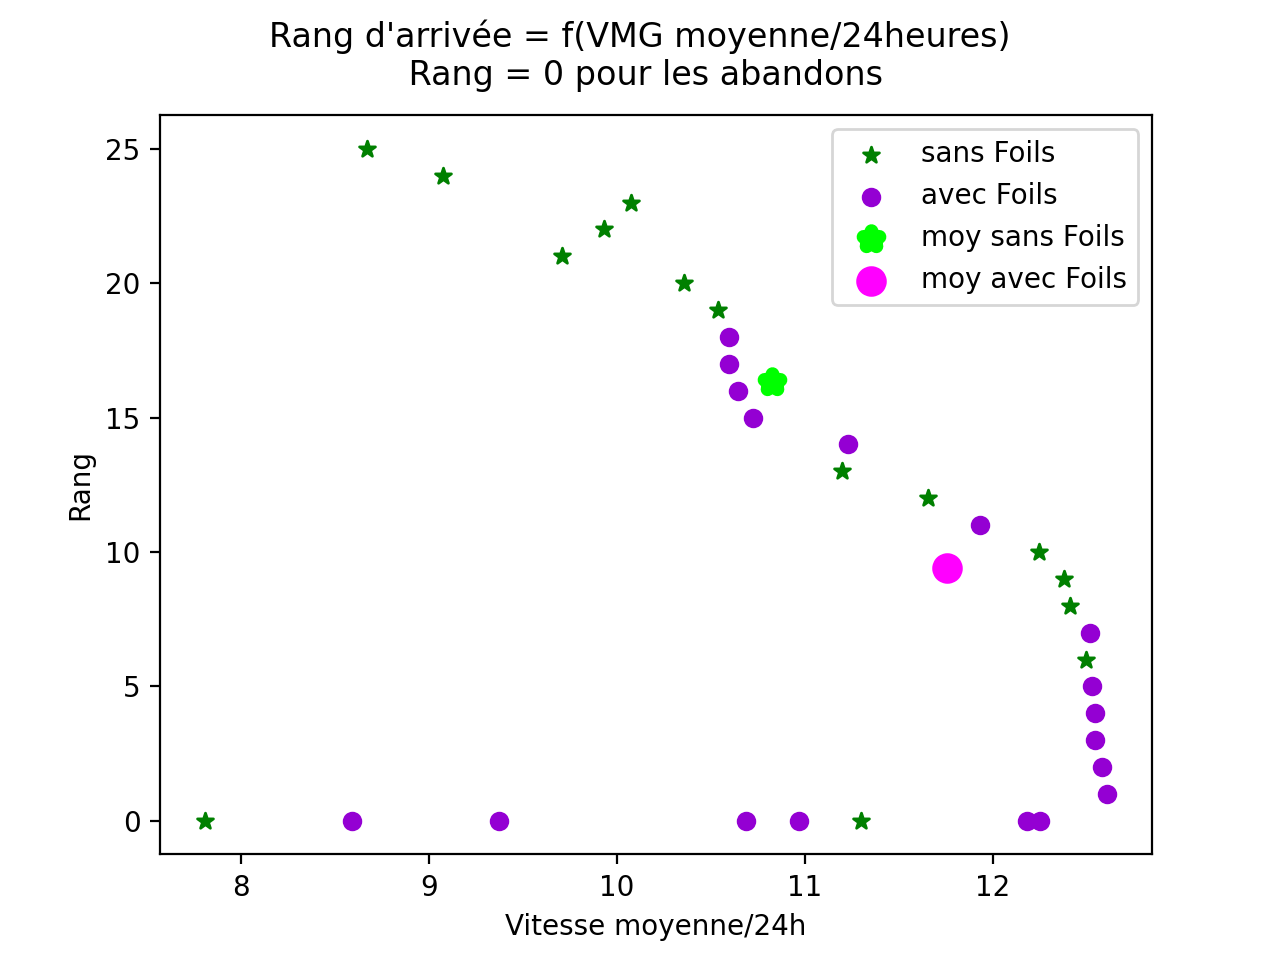

matplotlib.axes._subplots.AxesSubplot

In [139]:
#Représentation graphique
fig1,ax=plt.subplots()
plt.scatter(df_stats_foils.loc['non','VMG Depuis 24 heures (kts)']['mean'],df_stats_foils.loc['non','LRang'],marker ='*', color='green',label='sans Foils')
plt.scatter(df_stats_foils.loc['oui','VMG Depuis 24 heures (kts)']['mean'],df_stats_foils.loc['oui','LRang'],marker ='o', color='darkviolet', label='avec Foils')
ax.figure.suptitle ('Rang d\'arrivée = f(VMG moyenne/24heures)\n Rang = 0 pour les abandons')
ax.set_xlabel('Vitesse moyenne/24h')
ax.set_ylabel('Rang')
vfoil = df_stats_foils[df_stats_foils['LRang']!=0].loc['oui']['VMG Depuis 24 heures (kts)']['mean'].mean()
rfoil = df_stats_foils[df_stats_foils['LRang']!=0].loc['oui']['LRang'].mean()
v_nofoil = df_stats_foils[df_stats_foils['LRang']!=0].loc['non']['VMG Depuis 24 heures (kts)']['mean'].mean()
r_nofoil = df_stats_foils[df_stats_foils['LRang']!=0].loc['non']['LRang'].mean()
plt.scatter(v_nofoil,r_nofoil, color='lime', marker='*', linewidth=5, label='moy sans Foils')
plt.scatter(vfoil,rfoil, color='magenta', marker='o', linewidth=5,  label='moy avec Foils')

plt.legend();

type(ax)

### Conclusion :
On constate que les voiliers équipés de foils présentent des meilleurs résulats : 
- 6 voiliers sur les 10 premiers en possèdent un 
- leur vitesse moyenne est augmentée de 1kt environ. 


# Visualisation de la distance parcourue pour chaque voilier

In [140]:
df_distance=df_RVMG[['Bateau','Skipper','Distance Depuis le dernier classement (nm)']].groupby(['Bateau','Skipper']).agg(['sum','mean'])
df_stats_foils= df_stats_foils.reset_index()
df_distance= df_distance.reset_index()

In [141]:
df_distance
df_distance['LRang']= df_distance['Bateau'].apply(lambda x: df_stats_foils.loc[(df_stats_foils['Bateau']==x)]['LRang'].values.squeeze())
df_distance.sort_values(['LRang'],inplace= True)
df_distance.head()

Bateau              Skipper  \
                                                    
1               ARKEA PAPREC      Sébastien Simon   
24                       PRB      Kevin Escoffier   
21  NEWREST - ART & FENÊTRES       Fabrice Amedeo   
6            CORUM L'EPARGNE     Nicolas Troussel   
19                     MERCI  Sébastien Destremau   

   Distance Depuis le dernier classement (nm)            LRang  
                                          sum       mean        
1                                      8689.3  54.995570   0.0  
24                                     7661.3  55.921898   0.0  
21                                     8404.5  42.022500   0.0  
6                                      2485.0  49.700000   0.0  
19                                    15755.2  37.782254   0.0

## Conclusion :
- La dispersion des distances parcourues (hors abandon) reflète la diversité des routes empruntées. Celà peut tenir à différents facteurs : prise en compte météo, prise en compte des risques de casse...
- On constate aussi que les distances journalières moyennes des skippers ayant abandonné étaient très élevées, ce qui a favorisé les risques de casse.

In [151]:
df_etude_dist=df_RVMG.loc[:,['Date','Skipper','Distance Depuis le dernier classement (nm)']]
df_etude_dist.sort_values(['Date'])
df_etude_dist['jour']= df_etude_dist['Date'].apply(lambda x: pd.Timestamp.date(x))

d=df_etude_dist.groupby(['jour','Skipper']).agg({'Distance Depuis le dernier classement (nm)':['sum']})

d=d.unstack('Skipper')
d

Distance Depuis le dernier classement (nm)               \
                                                  sum                
Skipper                                    Alan Roura Alex Thomson   
jour                                                                 
2020-11-08                                      108.2        119.4   
2020-11-09                                      237.7        255.9   
2020-11-10                                      219.9        269.2   
2020-11-11                                      260.2        299.9   
2020-11-12                                      293.1        322.6   
...                                               ...          ...   
2021-03-01                                        NaN          NaN   
2021-03-02                                        NaN          NaN   
2021-03-03                                        NaN          NaN   
2021-03-04                                        NaN          NaN   
2021-03-05                                        NaN          NaN   

                                                                      \
                                                                       
Skipper    Alexia Barrier Ari Huusela Armel Tripon Arnaud Boissieres   
jour                                                                   
2020-11-08           89.9        86.7        133.7               0.0   
2020-11-09          217.8       196.9        285.4             224.5   
2020-11-10          185.3       224.0        260.0             195.3   
2020-11-11          205.5       225.2        214.0             251.7   
2020-11-12          206.8       224.3        221.2             269.3   
...                   ...         ...          ...               ...   
2021-03-01            NaN       176.7          NaN               NaN   
2021-03-02            NaN       135.0          NaN               NaN   
2021-03-03            NaN       249.6          NaN               NaN   
2021-03-04            NaN       186.8          NaN               NaN   
2021-03-05            NaN        62.2          NaN               NaN   

                                                                          ...  \
                                                                          ...   
Skipper    Benjamin Dutreux Boris Herrmann Charlie Dalin Clarisse Cremer  ...   
jour                                                                      ...   
2020-11-08            107.4          122.7          94.4           108.8  ...   
2020-11-09            246.1          273.5         300.4           256.7  ...   
2020-11-10            223.1          264.9         270.8           232.1  ...   
2020-11-11            282.3          231.0         304.5           257.6  ...   
2020-11-12            317.0          301.8         344.7           301.4  ...   
...                     ...            ...           ...             ...  ...   
2021-03-01              NaN            NaN           NaN             NaN  ...   
2021-03-02              NaN            NaN           NaN             NaN  ...   
2021-03-03              NaN            NaN           NaN             NaN  ...   
2021-03-04              NaN            NaN           NaN             NaN  ...   
2021-03-05              NaN            NaN           NaN             NaN  ...   

                                                                      \
                                                                       
Skipper    Miranda Merron Nicolas Troussel Pip Hare Romain Attanasio   
jour                                                                   
2020-11-08           95.5            136.4     96.8            106.8   
2020-11-09          214.3            304.4    231.0            236.7   
2020-11-10          203.4            240.2    211.8            220.7   
2020-11-11          218.4            283.0    250.3            270.1   
2020-11-12          249.1            323.5    258.7            309.2   
...            

In [142]:
d=df_etude_dist.groupby(['jour','Skipper']).agg({'Distance Depuis le dernier classement (nm)':['sum']})
d=d.reset_index()
d=d.T.droplevel(1).T
fig = go.Figure(data=go.Heatmap(
        z=d['Distance Depuis le dernier classement (nm)'],
        y=d['Skipper'],
        x=d['jour'],
        colorscale='Viridis'))

fig.update_layout(
    title='Sommes des Distances Depuis le dernier classement (nm) par jour de course',
    xaxis_nticks=100)

fig.show()



La Heatmap permet de se rendre facilement compte des grandes variations et les événements particulier. Celle-ci montre la distance parcourue pour chaque jour. 
Plus les cases sont claires, plus la distance est grande. 
On peut constater :
- une homogénéïté de couleur au départ de la course : c'est logique, tout le monde est au même endroit au même moment donc avec les mêmes conditions météo. Le début de la course est d'ailleurs plutôt foncé, ce qui signifie que globalement les distances parcourues restent modérées, c'est un début de course calme. 
- Ensuite, on observe des premiers pics de distance parcourus en un jour, entre le 15 et le 21 novembre. Probablement une météo plus favorable.
- ensuite à nouveau un bande plus sombre ce qui signifie des plus petites distances et des conditions météo plus calmes pour tout le monde. 
- Suite à cette période calme on observe des grosses accélérations chez plusieurs participants autour du 28 novembre. Les conditions météo s'y prêtent, mais le prix à payer est important : 4 abandons juste après ces pointes de distance, probablement consécutifs à des casses pour avoir voulu naviguer trop vite dans des conditions soutenues.
- de façon plus générale, la heatmamp permet de bien voir l'enchaînement de la course, les abandons successifs, la succession temporelle à l'arrivée. Le dernier arrivé a une course 30% plus longue que les premiers arrivés! 
- d'ailleurs, si l'on compare la couleur moyenne des lignes correspondants à ces skippers, on voit que celle du premier arrivé a une teinte moyenne plus claire. Elle reste cependant homogène : pas de folies en pointes de distance, plutôt un marathon de fond soutenu et bien mené. Très peu de jours de relâche aussi, les cases n'étant quasiment jamais foncées. 

In [150]:
# Je propose de faire le même graphique avec Plotly, en utilisant en plus le faceting pour séparer les finishers des autres et regarder si la présence de foils influe sur la distance parcourue
# On ajoute les Foils et un discret sur l'abandon ou pas 
df_distance=df_RVMG[['Bateau','Skipper','Distance Depuis le dernier classement (nm)','Distance Depuis 24 heures (nm)']].groupby(['Bateau','Skipper']).agg('sum')
df_distance= df_distance.reset_index()
df_distance['LRang']= df_distance['Bateau'].apply(lambda x: df_stats_foils.loc[(df_stats_foils['Bateau']==x)]['LRang'].values.squeeze())
df_distance['adandon'] = df_distance['LRang'].apply (lambda x: 'Oui' if x==0 else 'Non')
df_distance
df_l=df_bateau.loc[:,['Foils','Skipper']].copy()
df_test=pd.merge(df_distance,df_l, how="left", on='Skipper',sort=True)

fig = px.bar(df_test, x="Skipper", y="Distance Depuis le dernier classement (nm)", facet_col="Foils", facet_row="adandon")
fig.update_layout(xaxis={'categoryorder':'total ascending'})
fig.show()

<IPython.core.display.Javascript object>


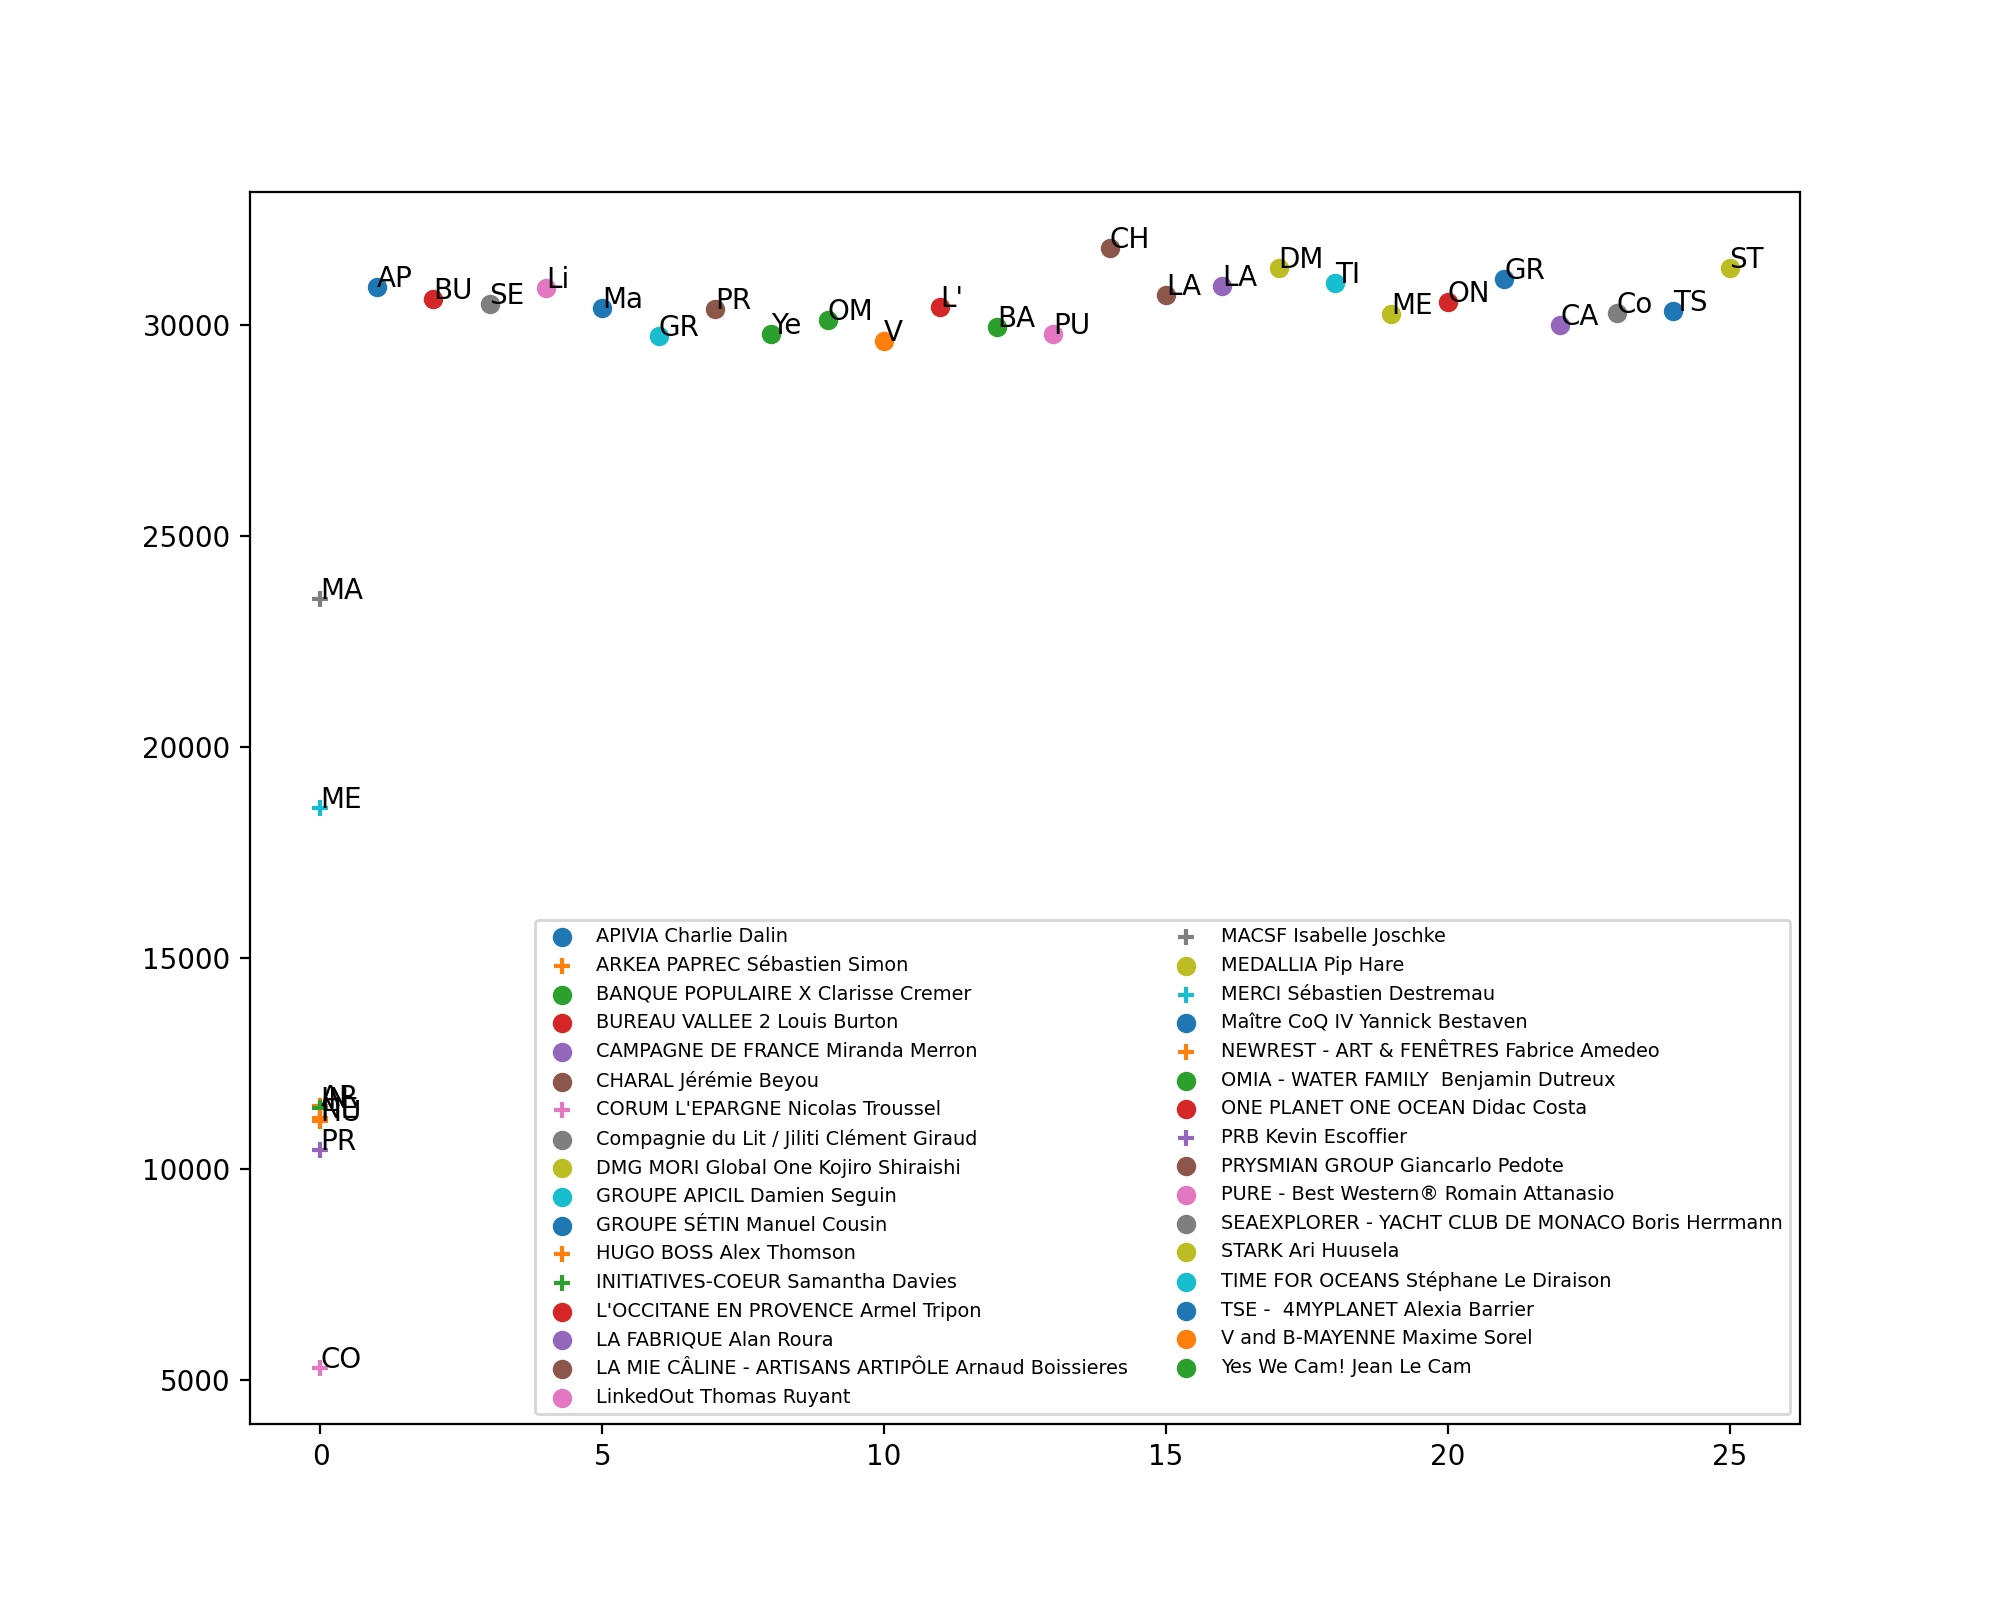

In [23]:
fig2,ax=plt.subplots(figsize=(10,8))
for i in df_distance.index:
    x=df_distance.loc[[i],['Bateau','Distance Depuis le dernier classement (nm)','LRang','Skipper']].values[0][3]
    y=df_distance.loc[[i],['Bateau','Distance Depuis le dernier classement (nm)','LRang','Skipper']].values[0][1]
    lbl=df_distance.loc[[i],['Bateau','Distance Depuis le dernier classement (nm)','LRang','Skipper']].values[0][0]
    s=df_distance.loc[[i],['Bateau','Distance Depuis le dernier classement (nm)','LRang','Skipper']].values[0][4]
    mark='o'
    if x==0:
        mark='+'
    ax = plt.scatter(x,y, label=lbl +' ' +s, marker=mark)
    
    plt.annotate(lbl[0:2], (x, y), xycoords='data')

plt.legend(ncol=2, fontsize ='x-small');


# Cartes avec les routes d'un ou plusieurs voiliers

In [77]:
df_trajectoire = pd.DataFrame(df_RVMG[['Date', 'Skipper','Bateau', 'Latitude', 'Longitude','Rang']])
df_trajectoire

Date           Skipper              Bateau   Latitude  \
0     2021-03-05 04:00:00       Ari Huusela               STARK  46.722500   
1     2021-03-04 21:00:00       Ari Huusela               STARK  47.145556   
2     2021-03-04 17:00:00       Ari Huusela               STARK  47.192500   
3     2021-03-04 14:00:00       Ari Huusela               STARK  47.222778   
4     2021-03-04 11:00:00       Ari Huusela               STARK  47.153056   
...                   ...               ...                 ...        ...   
15267 2020-11-08 14:00:00    Alexia Barrier    TSE -  4MYPLANET  46.439722   
15268 2020-11-08 14:00:00  Isabelle Joschke               MACSF  46.427222   
15269 2020-11-08 14:00:00   Sébastien Simon        ARKEA PAPREC  46.437500   
15270 2020-11-08 14:00:00    Miranda Merron  CAMPAGNE DE FRANCE  46.427500   
15271 2020-11-08 14:00:00       Ari Huusela               STARK  46.434722   

       Longitude Rang  
0      -1.557778   25  
1      -2.175000   25  
2      -3.290000   25  
3      -4.647500   25  
4      -4.413611   25  
...          ...  ...  
15267  -0.174444   27  
15268  -0.193889   28  
15269  -0.179722   29  
15270  -0.190556   30  
15271  -0.194167   31  

[15272 rows x 6 columns]

<IPython.core.display.Javascript object>


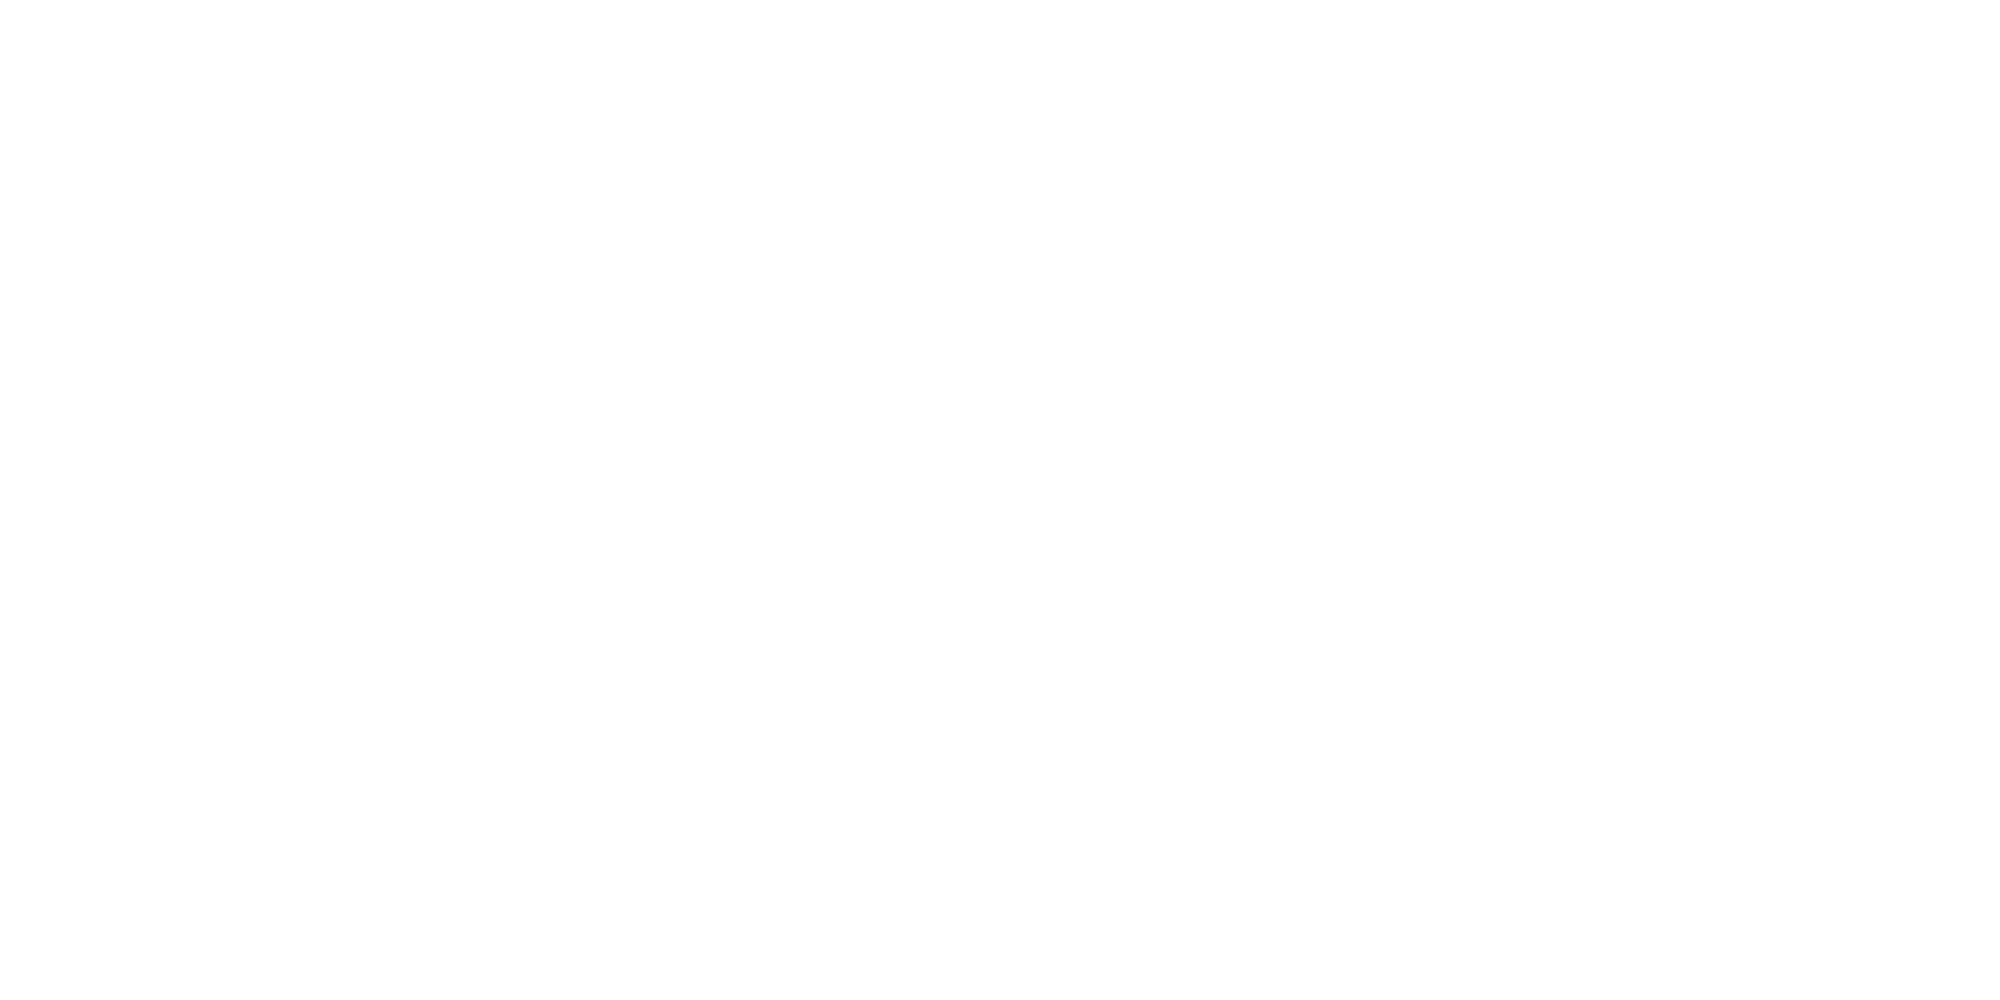

Shell is not a LinearRing
Shell is not a LinearRing


ValueError: Null geometry supports no operations

In [78]:
import cartopy.crs as ccrs
#Tracer des Trajectoires pour une liste de Bateaux/Skippers 
# Fournir une liste avec des Skippers ou des bateaux (Peu importe on retrouve les noms et on enlève les doublons )
Liste = ['Alexia', 'Ari' , 'Isabelle' , 'ARKE', 'APIVIA','Miranda']
colors =['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
Jour='25/12/2020'
Type = 'NearsidePerspective' # 1: NearsidePerspective 2 : platecarree 3 et autres: Mollweide
# autoloc : se centre sur la tête de course à la date du jour, sinon préciser les coordonnées central_lat et long 
#############################################################

def trace_cartopy(df_trajectoire,df_distance,Liste, colors, Jour=None, Type= 1 , cent_latitude=0,  cent_longitude=0, satellite_height=10000000.0, autoloc = False):
    plt.figure(tight_layout=True,figsize=(10, 5))
    Lat = cent_latitude
    Lon = cent_longitude
    l=df_distance[['Bateau']].values
    k=df_distance[['Skipper']].values 
    v={ l[key][0]:k[key][0]  for key,i in enumerate(l)}
    v.update({ k[key][0]:k[key][0]  for key,i in enumerate(l)})
    l_skip = [[ v[key] for key in v if t in key ] for t in Liste]
    l_skip=list(set([item for sublist in l_skip for item in sublist]))
    if Jour!= None :
        j = Jour.split('/')
        df_t = df_trajectoire.loc[(df_trajectoire['Date']<= dt.datetime(int(j[2]),int(j[1]),int(j[0])))]
        df_trajectoire=df_trajectoire.loc[(df_trajectoire['Date']<= dt.datetime(int(j[2]),int(j[1]),int(j[0])))]
        if autoloc == True:
            id=list(df_t.loc[(df_t['Date']>= 
            dt.datetime(int(j[2]),int(j[1]),int(j[0])-1)) & (df_t['Date']<= dt.datetime(int(j[2]),int(j[1]),int(j[0])) )]['Rang'].index)[0:5]
            Lat = df_t.loc[id,['Latitude']].mean()
            Lon = df_t.loc[id,['Longitude']].mean()
            
    
    
    if Type == 2 :
        ax = plt.axes(projection=ctp.crs.PlateCarree())
        ax.add_feature(ctp.feature.OCEAN)
        ax.add_feature(ctp.feature.COASTLINE)
        ax.stock_img()
    
    elif Type == 1: 
        ax = plt.axes(projection=ctp.crs.NearsidePerspective(
                        central_latitude = float(Lat),
                        central_longitude = float(Lon),
                        satellite_height=satellite_height))
        ax.add_feature(ctp.feature.OCEAN)
        ax.add_feature(ctp.feature.COASTLINE)
        ax.add_feature(ctp.feature.LAND)
        ax.coastlines(resolution='110m')
        ax.stock_img()
    else :
        ax= plt.axes(projection = ctp.crs.Mollweide())
        ax.add_feature(ctp.feature.OCEAN)
        ax.add_feature(ctp.feature.COASTLINE)
        ax.add_feature(ctp.feature.LAND)
        ax.coastlines(resolution='110m')
        ax.stock_img()

#Repérer le point de passage à la longitude 180 pour éviter une ligne d'Est en Ouest sur les cartes 
    index_passage_L180 ={}
    for dfx in df_trajectoire.groupby(['Skipper']):
        df1=dfx[1].sort_values(['Date'], ascending = True)[:-1]
        df2=dfx[1].sort_values(['Date'], ascending = True)[1:]
        df1=df1.reset_index().reset_index()
        df1=df1.rename({"index": "findex"},axis=1)
        df2=df2.reset_index().reset_index()
        df2=df2.rename({"index": "findex"},axis=1)
        dfm=df1.merge(df2,how='left',  right_on='level_0',left_on='level_0',suffixes=('','_y'))
        dfm['chg']= dfm.apply(lambda x: x['Longitude']*x['Longitude_y'] if x['Longitude']*x['Longitude_y']<-30000 else 'Nok',axis=1)
        if dfm.loc[dfm['chg']!='Nok'].size !=0:
             index_passage_L180[dfx[0]]=dfm.loc[dfm['chg']!='Nok'].values[0][1]
        else:
             index_passage_L180[dfx[0]]=0

# Tracé des trajectoires désirées dans Liste     
    c=0
    
    for skip in l_skip: 
  
            #retour            
            x=df_trajectoire['Longitude'].loc[(df_trajectoire['Skipper']==skip) & (df_trajectoire.index < int(index_passage_L180[skip]) )]
            y=df_trajectoire['Latitude'].loc[(df_trajectoire['Skipper']==skip) & (df_trajectoire.index < int(index_passage_L180[skip]) )]
            ax.plot(x,y, transform =ctp.crs.PlateCarree(),color=colors[c] )
           #aller                
            x=df_trajectoire['Longitude'].loc[(df_trajectoire['Skipper']==skip) & (df_trajectoire.index >= int(index_passage_L180[skip]) )]
            y=df_trajectoire['Latitude'].loc[(df_trajectoire['Skipper']==skip) & (df_trajectoire.index >= int(index_passage_L180[skip]) )]
            ax.plot(x,y,label = skip, transform =ctp.crs.PlateCarree(), color=colors[c])
            if c==len(colors)-1: 
                c=0
            c=c+1
    
    

    ax.set_xlabel('x label')  # Add an x-label to the axes.
    ax.set_ylabel('y label')  # Add a y-label to the axes.
    ax.set_title("Vendée Globle Challenge "+ Jour )
    plt.legend(fontsize='xx-small')
    plt.show()

trace_cartopy(df_trajectoire,df_distance,Liste, colors, Jour="12/12/2020", Type= 3 ,
              cent_latitude=-43,  cent_longitude=97, satellite_height=10000000.0, autoloc=False)



<IPython.core.display.Javascript object>


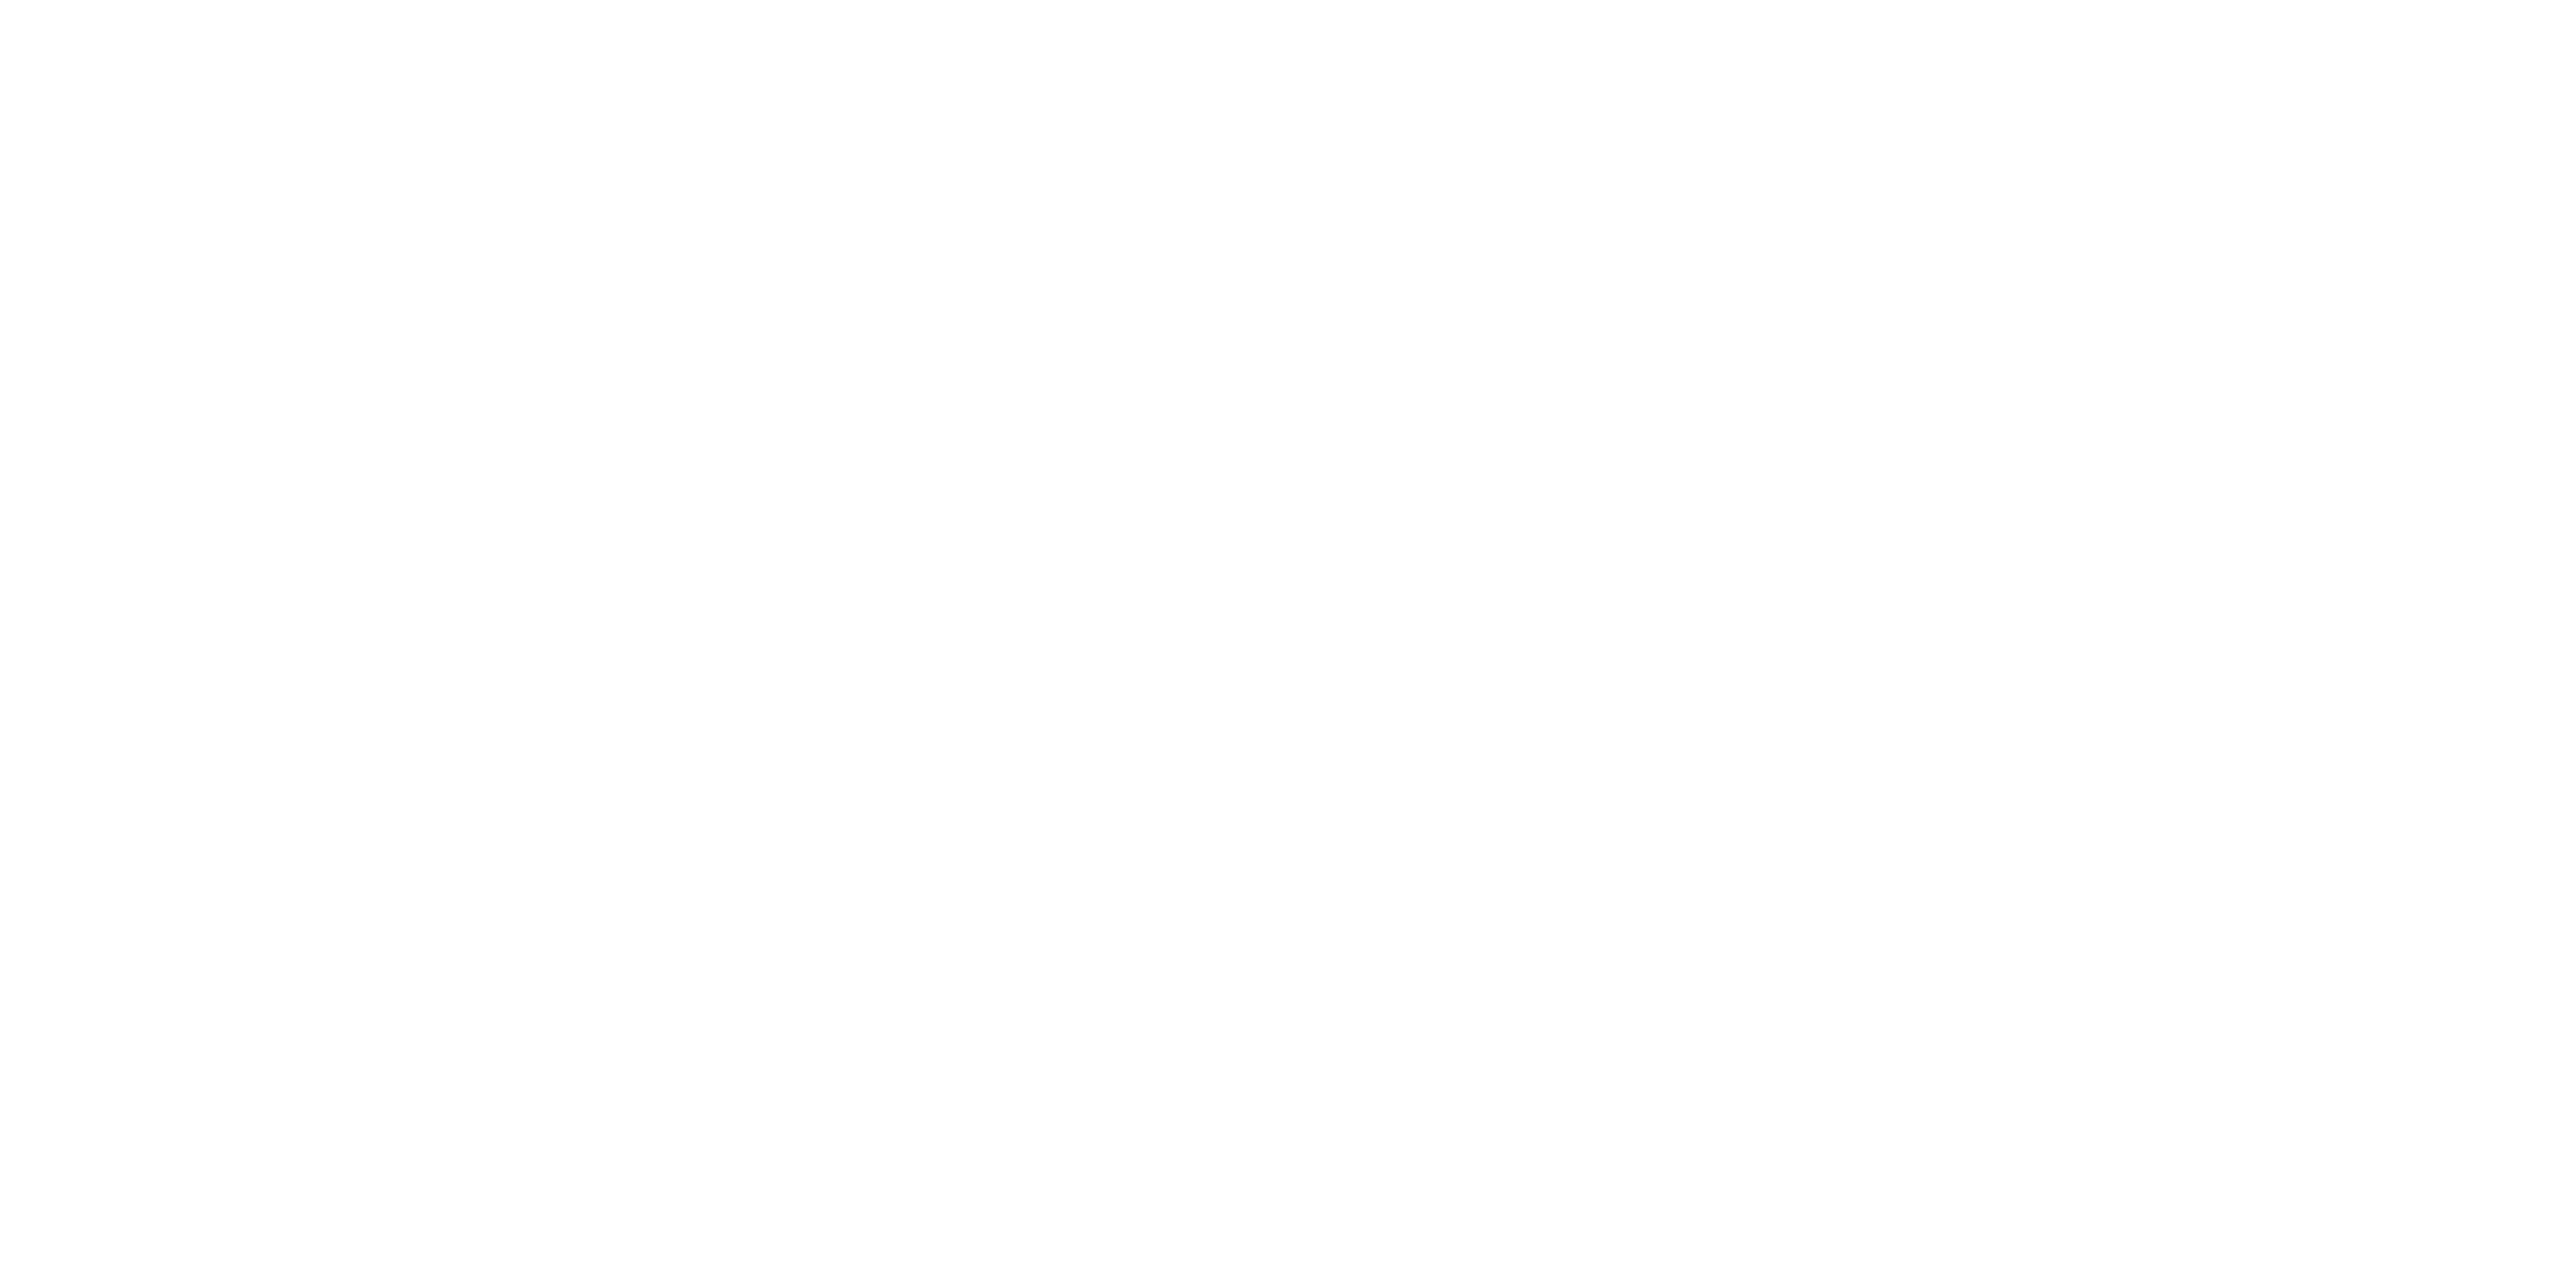

Shell is not a LinearRing
Shell is not a LinearRing


ValueError: Null geometry supports no operations

In [74]:
# On test l'autoloc sur la tête de course
trace_cartopy(df_trajectoire,df_distance,Liste, colors, Jour="15/01/2021", Type= 1,
              cent_latitude=0,  cent_longitude=0, satellite_height=10000000.0, autoloc=True)

## Conclusion :
J'ai rencontré de grosses difficultés à coder sous Cartopy, et en plus il y a des bugs sous mac. 

Je décide donc de coder une autre animation avec les bibliothèques de Plotly. 

In [81]:
import plotly.express as px

fig = px.line_geo(df_trajectoire.loc[(df_trajectoire['Date']<= dt.datetime(2020,12,2))], lat="Latitude", lon="Longitude",
                  color="Bateau",
                  projection='orthographic',
                  hover_data={'Rang':True, 
                              'Date': True,
                            }
                 ) 
#    Projection['equirectangular', 'mercator', 'orthographic', 'natural earth',
#              'kavrayskiy7', 'miller', 'robinson', 'eckert4',
#            'azimuthal equal area', 'azimuthal equidistant', 'conic
#            equal area', 'conic conformal', 'conic equidistant',
#            'gnomonic', 'stereographic', 'mollweide', 'hammer',
#            'transverse mercator', 'albers usa', 'winkel tripel',
#            'aitoff', 'sinusoidal']
fig.show()

## Utilisation de Plotly

Préparation du dataframe avec un classement par jour.

Même si le fichier est déjà éxécuté, vous pouvez faire bouger le curseur avec votre souris pour jouer l'évolution de la course à votre guise, ou appuyer sur "play".

In [153]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly as py
init_notebook_mode(connected=True) 
import plotly.graph_objs

In [154]:
df_animation_py =  df_trajectoire.copy()
df_animation_py['jour']= df_animation_py['Date'].apply(lambda x: pd.Timestamp.date(x))
group=df_animation_py.groupby(['Skipper','Bateau','jour'])
idx=[]
for g in group:
    idx.append(g[1]['Date'].idxmax())
df_a=df_animation_py.iloc[idx]

df_a

Date           Skipper         Bateau   Latitude  \
15170 2020-11-08 21:00:00        Alan Roura    LA FABRIQUE  46.470000   
14971 2020-11-09 21:00:00        Alan Roura    LA FABRIQUE  45.452222   
14772 2020-11-10 21:00:00        Alan Roura    LA FABRIQUE  43.719167   
14568 2020-11-11 21:00:00        Alan Roura    LA FABRIQUE  41.381389   
14369 2020-11-12 21:00:00        Alan Roura    LA FABRIQUE  38.136111   
...                   ...               ...            ...        ...   
2123  2021-01-23 21:00:00  Yannick Bestaven  Maître CoQ IV  34.089444   
1973  2021-01-24 21:00:00  Yannick Bestaven  Maître CoQ IV  40.224444   
1823  2021-01-25 21:00:00  Yannick Bestaven  Maître CoQ IV  44.086944   
1673  2021-01-26 21:00:00  Yannick Bestaven  Maître CoQ IV  47.595833   
1548  2021-01-27 17:00:00  Yannick Bestaven  Maître CoQ IV  47.495556   

       Longitude Rang        jour  
15170  -3.573611   27  2020-11-08  
14971  -8.800833   26  2020-11-09  
14772 -11.094167   25  2020-11-10  
14568 -16.693611   19  2020-11-11  
14369 -20.140000   18  2020-11-12  
...          ...  ...         ...  
2123  -28.592222    5  2021-01-23  
1973  -26.572222    5  2021-01-24  
1823  -21.133056    5  2021-01-25  
1673  -14.158333    5  2021-01-26  
1548   -5.411944    5  2021-01-27  

[2570 rows x 7 columns]

In [155]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly as py
init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import warnings            
warnings.filterwarnings("ignore") 
import os

jours = [each for each in list(df_a.jour.unique())]  #Tous les jours du DF
Bateaux = [str(each) for each in list(df_a.Bateau.unique())]
Skippers =  [str(each) for each in list(df_a.Skipper.unique())]

figure = {
    'data': [],
    'layout': {},
    'frames': []
}


figure['layout']['geo'] = dict(projection_type="orthographic",showframe=False, showland=True, showcoastlines=True, showcountries=True,
               countrywidth=1, 
              landcolor = 'rgb(217, 217, 217)',
              subunitwidth=1,
              showlakes = True,
              lakecolor = 'rgb(255, 255, 255)',
              countrycolor="rgb(5, 5, 5)")
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '2020-11-08',
    'plotlycommand': 'animate',
    'values': jours,
    'visible': True
}

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Jour:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

jour = dt.datetime(2020,11,8)
for ba in Bateaux:
    dataset_by_jour = df_a[df_a['jour'] == jour]
    dataset_by_jour_and_bateau = dataset_by_jour[dataset_by_jour['Bateau'] == ba]
    
    data_dict = dict(
    type='scattergeo',
    lon = dataset_by_jour_and_bateau['Longitude'],
    lat = dataset_by_jour_and_bateau['Latitude'],
    hoverinfo = 'text',
    text = ba,
    mode = 'markers',
    marker=dict(
        sizemode = 'area',
        sizeref = 1,
        size= 10 ,
        line = dict(width=1,color = "white"),
        #color = custom_colors[ty],
        opacity = 0.7),
)
    figure['data'].append(data_dict)
    
# Stockage des données par jour
for jour in jours:
    frame = {'data': [], 'name': str(jour)}
    for ba in Bateaux:
        dataset_by_jour = df_a[df_a['jour'] == jour]
        dataset_by_jour_and_bateau = dataset_by_jour[dataset_by_jour['Bateau'] == ba]
        data_dict = dict(
                type='scattergeo',
                lon = dataset_by_jour_and_bateau['Longitude'],
                lat = dataset_by_jour_and_bateau['Latitude'],
                hoverinfo = 'text',
                text = ba + ' rang = ' + str(dataset_by_jour_and_bateau['Rang'].values) ,
                mode = 'markers',
                marker=dict(
                    sizemode = 'area',
                    sizeref = 1,
                    size= 10 ,
                    line = dict(width=1,color = "white"),
                    #color = custom_colors[ty],
                    opacity = 0.7),
                name = ba
            )
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [jour],
        {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': str(jour),
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure["layout"]["autosize"]= True
figure["layout"]["title"] = "Vendée Globe : The Race"       

figure['layout']['sliders'] = [sliders_dict]

iplot(figure)



In [160]:
# pour une date de début et une date de fin pour un autre type de projection
début='30/11/2020' 
fin = '05/12/2020'
dtdebut = dt.datetime(int(début.split('/')[2]),int(début.split('/')[1]),int(début.split('/')[0]))
dtfin = dt.datetime(int(fin.split('/')[2]),int(fin.split('/')[1]),int(fin.split('/')[0]))
 

##################################
df=df_trajectoire.loc[(df_trajectoire['Date']>=dtdebut) & (df_trajectoire['Date']<=dtfin)].copy()

fig = px.line_geo(df, lat="Latitude", lon="Longitude",
                  color="Bateau",
                  projection='mollweide',
                  hover_data={'Rang':True, 
                              'Date': True},
                  title = 'Vendée globe entre le ' +début + ' et le '+ fin
                           
                 ) 
#    Projection['equirectangular', 'mercator', 'orthographic', 'natural earth',
#              'kavrayskiy7', 'miller', 'robinson', 'eckert4',
#            'azimuthal equal area', 'azimuthal equidistant', 'conic
#            equal area', 'conic conformal', 'conic equidistant',
#            'gnomonic', 'stereographic', 'mollweide', 'hammer',
#            'transverse mercator', 'albers usa', 'winkel tripel',
#            'aitoff', 'sinusoidal']
fig.show()

# Analyses de séries temporelles

On va analyser le classement en fonction du temps


In [161]:
# Affiche les rangs en fonction du temps pour : un nombre de skipper tirés au hasard ou une liste précise de Skippers
def serie_classement(df, nombre_skipper_aff,liste_précise=None):
    Skippers = df["Skipper"].unique()
    plt.subplots(figsize=(10, 7))
    plt.title("Rang en fonction du temps")
    if liste_précise == None:
        random.shuffle(Skippers)
    
    else: 
        Sk = [s for s in liste_précise if s in Skippers]
        print(Sk, Skippers, liste_précise)
        Skippers = Sk
       
    
    for skip in Skippers[:min(len(Skippers),nombre_skipper_aff)]:
        rang = df['Rang'].loc[(df["Skipper"] == skip)]
        dates = df['Date'].loc[(df["Skipper"] == skip)]
        plt.plot(dates, rang, label = skip)
    
    plt.xlabel("Date")
    plt.ylabel("Rang")
    plt.legend(fontsize='xx-small')
    return 

#['Louis Burton' 'Boris Herrmann' 'Jérémie Beyou' 'Thomas Ruyant'
# 'Maxime Sorel' 'Fabrice Amedeo' 'Jean Le Cam' 'Alex Thomson'
# 'Sébastien Destremau' 'Pip Hare' 'Kevin Escoffier' 'Stéphane Le Diraison'
# 'Romain Attanasio' 'Damien Seguin' 'Clément Giraud' 'Samantha Davies'
# 'Yannick Bestaven' 'Giancarlo Pedote' 'Kojiro Shiraishi'
# 'Nicolas Troussel' 'Manuel Cousin' 'Clarisse Cremer' 'Alan Roura'
# 'Didac Costa' 'Benjamin Dutreux' 'Armel Tripon' 'Alexia Barrier'
# 'Isabelle Joschke' 'Sébastien Simon' 'Miranda Merron' 'Ari Huusela'
# 'Charlie Dalin' 'Arnaud Boissieres']

<IPython.core.display.Javascript object>


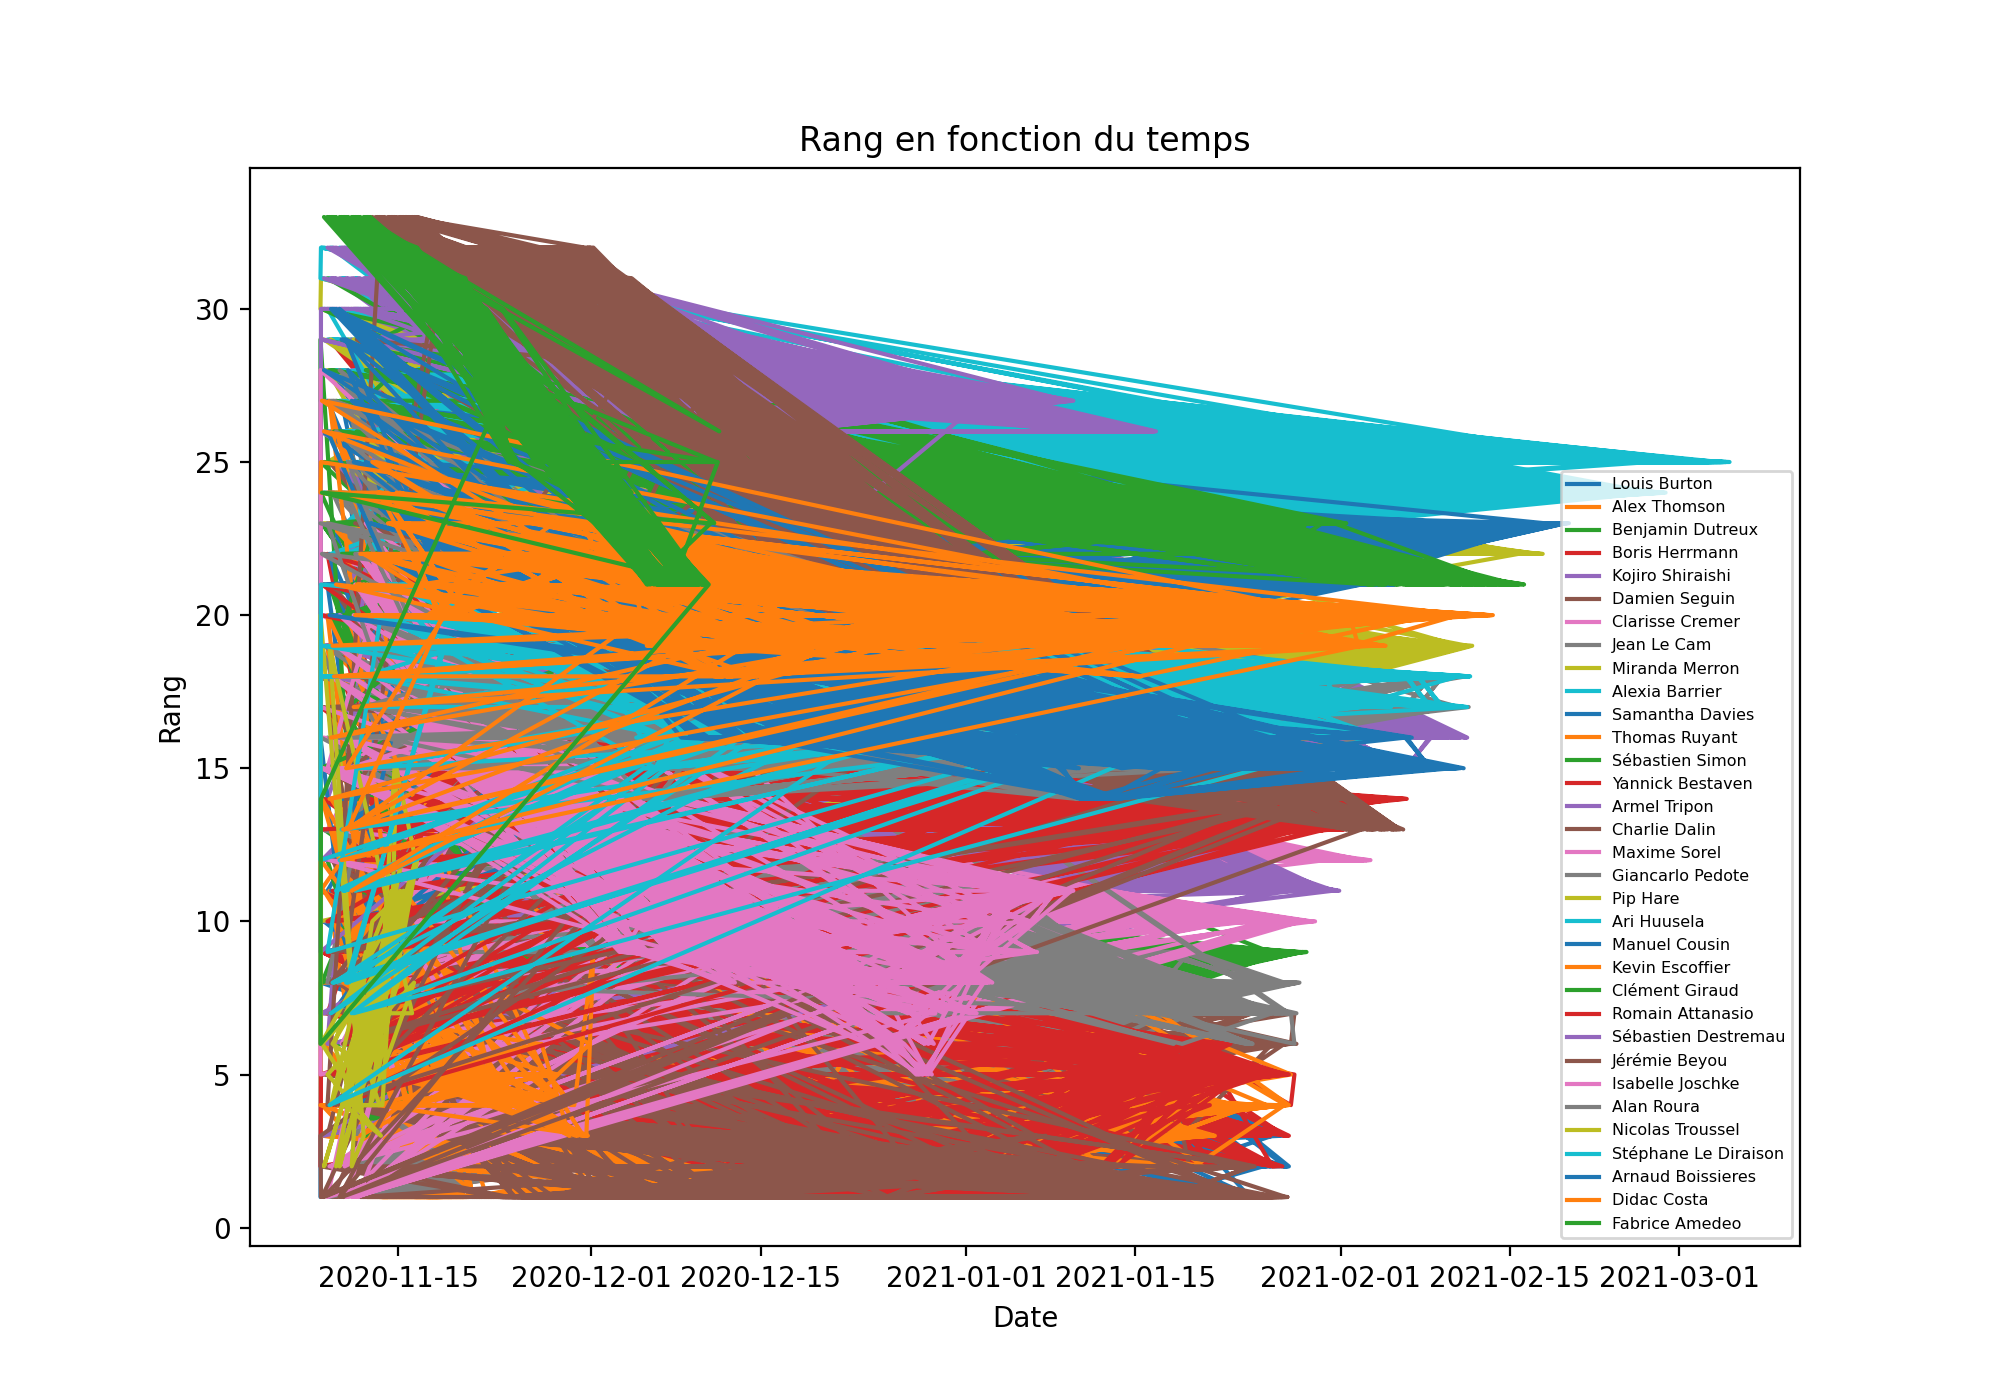

In [163]:
# pour une liste précise
liste = ['Giancarlo Pedote', 'Clarisse Cremer', 'Alex Thomson', 'Fabrice Amedeo']
# 'Yannick Bestaven' 'Giancarlo Pedote'
serie_classement(df_classement,33)
#Avec Plotly express, on dispose en plus d'une capacité d'interaction. 

fig = px.line(df_RVMG, x="Date", y="Rang", color='Skipper',facet_col="Foils", title='Vendée Globe 2020 Rang= f(t)')
fig.show()


## Analyse

On voit très clairement les abandons (la ligne s'interrompt).

On voit aussi les sériées de skippers qui se font doubler en même temps, ceux qui se disputent une place au classement en échangeant leurs rangs plusieurs fois de suite...